In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

# k fold
from sklearn.model_selection import KFold

# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# linreg
from sklearn.linear_model import LinearRegression

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Also here it's paper algo!!! S(X) is estimated directly, like in the Chernozhukov's paper, unlike in other notebooks

# Difference to 6th DGP: b_0 and s_0 functions are switched!!!! Now b_0 is sparse, s_0 is not!!!

# Right now paper way of estimation seems better!!!! But also I have warnings in ElasticNet and some problems in LGBM (maybe the set of hyperparams is not good, so the optimal from this set is binding, so really optimal is not in my set!!!! Or in general something is wrong if going to the p>>n!!!!!!?????

# UPD: ACTUALLY THE STATEMENT ABOVE IS NOT SO OBVIOUS EVEN WHEN b_0 is not sparse and s_0 is sparse (6th DGP), but what if vice versa (7th DGP)!!!

# Here something strange happens with LGBM!!!!

# For baseline use LassoCV to choose lambda and also check papers (1 and 2) for UNBIASED 2-step procedure to find ATE (Since OLS cannot work in this case, as p >> n)!!!! If not CV, check theoretical value of Lambda in second paper (but need to work with factor loadings!!!)!!!!

# UPD: somehow, simple linear regression worked!!!!

# Should I use different data generating processes? I used similar, just generated more variables than observations, is it reasonable to try to make b_0 extremely complicated and not sparse, but heterogeneity function s_0 being sparse???!!! (Right now both b_0 and s_0 are sparse!!!). This may help to check whether my way of S(X) estimation is not far away from S(X) estimation in the paper!!!! But actually, I may just change the way of estimation everywhere!!!

# By the way, will it be Okay to deploy this code on public Github??? (If, for example, reference all the papers used?)

# Also ask about Master programmes!!!!

# Note: the whole notebook is automatized, so if check other DGPs, just copy the notebook, change ONE CELL with DGP and run the whole notebook (it's easy to do, run for 1.5-2 hours, depending on amount of data!!!)

# Also I can add depending on different datasplits, BLP metric is less stable, maybe this is the reason why it does not outperform. Also in some cases (no target tuning) higher BLP metric does not mean lower MAE, MSE!!!!
# Also Idea: combine BLP metric with GATES metric????? If relevant to do now, do now!!!!
# Or some other method of tuning???? (Not GridSearchCV???) Or target tuning algorithm (parts 'invented' by me) is not quite vaild!!!!???

# Some other idea!!!! Given tune_lambda_hat ML model for D = 1, optimize model for D = 0, based on the target!!!!! So it's double hyperparameter tuning, just some food for thought!!!! (Iteration proceedure)

# Also think about sample sizes, while tuning, maybe I can adjust it somehow, given that test size is larger if adding D = 0 data in target tuning!!!!???

# In target parameter tuning, validation set was lower than actual B sample by three times!!!! And validation set is almost equal to the training sets for ML estimations (I mean size of training sets during hypertuning)!!! (equal if propensity score = 0.5 on average)

# Also do proper check of the work, I am a little bit confused by the metrics, during tuning!!!

## Conclusion: even if not outperform MSE tuning, target tuning may bring alternative hyperparameters which may create more robust estimation, I CAN CHECK THAT?????

In [2]:
# importing main function from .py file with functions!!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_PAPER_ALGO

# import lambda hat function for tuning from .py file with functions!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import lambda_hat_tuning_CV

# importing other functions
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_compare_two_models_PAPER_ALGO
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_easy_baseline

## DGP which was not perfectly estimated by default ML estimations

In [3]:
np.random.seed(100)
# empty df
df = pd.DataFrame()
# NUMBER OF OBSERVATIONS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
obs = 270
# explanatory variables: X
df['x1'] = np.random.uniform(-1, 3, obs)
x2 = np.random.uniform(-6, 2, obs)
x3 = np.random.uniform(8, 14, obs)
k0, k1 = np.random.multivariate_normal([3, 5], [[1, 0.8], [0.8, 1]], obs).T
df['x4'] = k0 * 3
df['x5'] = k1 * 7
k2, k3, k4 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, 0.4, 0.5], 
                                                                            [0.4, 1, 0.9], 
                                                                            [0.5, 0.9, 1]]), obs).T
df['x6'] = k2 * 6
x7 = k2 * k3 - k4
df['x8'] = np.sin(k4)
k5, k6, k7 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                            [-0.4, 1, 0.9], 
                                                                            [-0.5, 0.9, 1]]), obs).T
df['x9'] = k5
df['x10'] = k6
df['x11'] = k7
x12 = np.random.uniform(-10, 20, obs)
df['x13'], k8, k9 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                                                    [-0.4, 1, 0.9], 
                                                                                                    [-0.5, 0.9, 1]]), obs).T

df['x14'] = np.random.uniform(-6, 2, obs)
df['x15'] = np.random.uniform(8, 14, obs)
df['x16'], df['x17'], df['x18'] = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.1, -0.5], 
                                                                                                    [-0.1, 1, 0], 
                                                                                                    [-0.5, 0, 1]]), obs).T
# NEW PART!!!!!!
for k in range (5, 255):
    name1 = 'x' + str(k * 5)
    name2 = 'x' + str(k * 5 + 1)
    name3 = 'x' + str(k * 5 + 2)
    name4 = 'x' + str(k * 5 + 3)
    name5 = 'x' + str(k * 5 + 4)
    matr = np.random.normal(0.5, 1.5, 25).reshape((5, 5))
    cov_matr = matr @ matr.T
    a, b, c, d, e = np.random.multivariate_normal(np.array([-1, 0.3, 1.7, 0, 0]), cov_matr, obs).T
    df[name1] = a
    df[name2] = b
    df[name3] = c
    df[name4] = d
    df[name5] = e
    
# NEW: MAKING b_0 NOT SPARSE!!!!
weights_list = list(np.random.uniform(-0.05, 0.25, len(x_cols[::3])))
linear_factor = np.zeros(df.shape[0])

for num, col in enumerate(x_cols[::3]):
    linear_factor = linear_factor + df[col] * weights_list[num]
        
eps = np.random.normal(0, 1024, obs)
eps1 = np.random.normal(0, 1024, obs)
# b(X) = Y(0)
df['b_0'] = 3 * df.x1 + x2 + df.x1 * x2 + df.x25 ** 2 * df.x27 * 3 + 7 * df.x34 * x7 + eps1

# propensity score: p(D = 1 | X), bounded from 0 and 1
df['p'] = (8 + df.x1 + x2 + x3 * 0.5) / 32
# s(X) = Y(1) - Y(0)
df['s_0(X)'] = 4 + 6*df.x1 + 8*x2 - 9*df.x1*x2 + 3 * np.log(x3) -\
        np.maximum(df.x4, 0.3) **(1/3) * x3 + np.exp(x7 / 5) + np.maximum(0, df.x8) +\
        0.5 * (x7 - df.x8) * np.minimum(df.x6, -1) + np.minimum(df['x10'] - df['x11'] * (df['x9'] + x7), x12) +\
        linear_factor + eps

# whether the treatment was assigned (D), given propensity score
df['D'] = np.random.binomial(1, df.p)
# CREATION OF Y:
df['y'] = df.b_0 + df['s_0(X)'] * df.D

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['D'] = np.random.binomial(1, df.p)
C:\Users\052\AppData\Local\Temp\ipykernel_16488\3928955993.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y'] = df.b_0 + df['s_0(X)'] * df.D


In [ ]:
### Automatic search for the covariates columns AGAIN!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)

In [4]:
df.head()

,x1,x4,x5,x6,x8,x9,x10,x11,x13,x14,...,x1270,x1271,x1272,x1273,x1274,b_0,p,s_0(X),D,y
0,1.173620,15.783567,48.779728,-5.685639,0.745728,0.395395,-0.325419,1.224755,-2.279018,-4.619105,...,-1.353034,-1.761774,3.341376,-2.918566,-0.932758,-1261.569471,0.488986,-155.808723,0,-1261.569471
1,0.113478,4.438045,24.019415,-2.927082,0.779136,-1.448864,1.332845,2.441188,-1.509696,-3.180923,...,-3.002687,0.259409,0.482626,-3.024970,-2.644444,-1240.305162,0.398772,-142.123760,0,-1240.305162
2,0.698070,13.708881,42.534189,-4.178835,0.888943,-0.679539,1.991485,3.274681,-0.963150,-2.636642,...,-5.358939,0.862657,-2.614172,-0.533875,2.576377,915.826762,0.280332,-2175.847329,0,915.826762
3,2.379105,6.563017,31.407383,-1.870586,-0.033742,0.277188,-0.326752,1.426350,-0.814473,0.843613,...,-2.566396,-0.941067,2.499002,-3.106721,-0.994086,-656.663841,0.483574,-1204.880766,1,-1861.544608
4,-0.981125,9.600102,37.218350,-4.917191,0.852696,-0.758194,-0.838417,0.582920,-1.408251,-0.069436,...,-1.453032,-6.673956,1.309626,-5.791325,1.527457,-224.188993,0.399640,-1513.804861,1,-1737.993854


### Importing models

In [5]:
# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# 1) Tuning all models by minimisation of MSE of both B(X) and E(Y|X,D=1) modelling

In [6]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)
        
X_train0 = df_A[df_A['D'] == 0][x_cols]
y_train0 = df_A[df_A['D'] == 0]['y']
scaler0 = MinMaxScaler()
scaler0.fit(X_train0)
X_train0 = scaler0.transform(X_train0)

X_train1 = df_A[df_A['D'] == 1][x_cols]
y_train1 = df_A[df_A['D'] == 1]['y']
scaler1 = MinMaxScaler()
scaler1.fit(X_train1)
X_train1 = scaler1.transform(X_train1)

### Setting default models to tune

In [7]:
# rf
rf0 = RandomForestRegressor()
rf1 = RandomForestRegressor()

# Elastic net
elast0 = ElasticNet()
elast1 = ElasticNet()

# LightGBM
lgbm0 = LGBMRegressor()
lgbm1 = LGBMRegressor()

### a) Tuning rf

In [8]:
params_rf0 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

params_rf1 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

In [9]:
grid_rf0 = GridSearchCV(estimator = rf0, 
                        param_grid = params_rf0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_rf1 = GridSearchCV(estimator = rf1, 
                        param_grid = params_rf1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [10]:
grid_rf0.fit(X_train0, y_train0)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [11]:
grid_rf1.fit(X_train1, y_train1)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [12]:
grid_rf0.best_estimator_

RandomForestRegressor(min_impurity_decrease=0.01, n_estimators=250)

In [13]:
grid_rf1.best_estimator_

RandomForestRegressor(max_features='sqrt', min_impurity_decrease=0.001,
                      n_estimators=250)

In [14]:
rf0_tune_MSE = grid_rf0.best_estimator_
rf1_tune_MSE = grid_rf1.best_estimator_

### b) Tuning Elastic Net

In [15]:
elast0.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [16]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [17]:
params_elast0 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

params_elast1 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

In [18]:
grid_elast0 = GridSearchCV(estimator = elast0, 
                        param_grid = params_elast0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_elast1 = GridSearchCV(estimator = elast1, 
                        param_grid = params_elast1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [19]:
grid_elast0.fit(X_train0, y_train0)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.573e+03, tolerance: 5.234e+03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [20]:
grid_elast1.fit(X_train1, y_train1)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [21]:
grid_elast0.best_estimator_

ElasticNet(alpha=0.0001)

In [22]:
grid_elast1.best_estimator_

ElasticNet(alpha=1000, l1_ratio=0.2)

In [23]:
elast0_tune_MSE = grid_elast0.best_estimator_
elast1_tune_MSE = grid_elast1.best_estimator_

### c) Tuning Lgbm: 
# parameters are quite different from those optimized by Chernozhukov in the paper!!!!

In [24]:
lgbm0.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [25]:
# # What about adding reg_alpha and reg_lambda?????
params_lgbm0 = {'colsample_bytree': [0.02, 0.05, 0.07, 0.1], 
                 'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.07], 
                 'num_leaves': [2, 3, 5], 
                 'min_split_gain': [0, 0.0001], 
                 'min_child_weight': [0, 0.0001], 
                 'n_estimators': [2, 3], 
                 'silent': [False]}

params_lgbm1 = {'colsample_bytree': [0.02, 0.05, 0.07, 0.1], 
                 'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.07], 
                 'num_leaves': [2, 3, 5], 
                 'min_split_gain': [0, 0.0001], 
                 'min_child_weight': [0, 0.0001], 
                 'n_estimators': [2, 3], 
                 'silent': [False]}

In [26]:
grid_lgbm0 = GridSearchCV(estimator = lgbm0, 
                        param_grid = params_lgbm0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_lgbm1 = GridSearchCV(estimator = lgbm1, 
                        param_grid = params_lgbm1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [27]:
grid_lgbm0.fit(X_train0, y_train0)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 58.434745


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.02, 0.05, 0.07, 0.1],
                         'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05,
                                           0.07],
                         'min_child_weight': [0, 0.0001],
                         'min_split_gain': [0, 0.0001], 'n_estimators': [2, 3],
                         'num_leaves': [2, 3, 5], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [28]:
grid_lgbm1.fit(X_train1, y_train1)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score -53.833627


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.02, 0.05, 0.07, 0.1],
                         'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05,
                                           0.07],
                         'min_child_weight': [0, 0.0001],
                         'min_split_gain': [0, 0.0001], 'n_estimators': [2, 3],
                         'num_leaves': [2, 3, 5], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [29]:
grid_lgbm0.best_estimator_

LGBMRegressor(colsample_bytree=0.02, learning_rate=0.01, min_child_weight=0,
              min_split_gain=0, n_estimators=3, num_leaves=2, silent=False)

In [30]:
grid_lgbm1.best_estimator_

LGBMRegressor(colsample_bytree=0.02, learning_rate=0.003, min_child_weight=0,
              min_split_gain=0, n_estimators=2, num_leaves=2, silent=False)

In [31]:
lgbm0_tune_MSE = grid_lgbm0.best_estimator_
lgbm1_tune_MSE = grid_lgbm1.best_estimator_

# 2) Set of models, tuned by MSE (B(X)), target BLP metric (S(X)) + How they perform compared to models tuned by MSE only and to default non-tuned models!!!

In [32]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)

In [33]:
df_A_0 = df_A[df_A['D'] == 0].copy()
df_A_1 = df_A[df_A['D'] == 1].copy()

### a) Tuning rf: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [34]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# rf0_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 0, 
#                                      max_features = None, 
#                                      max_depth = 12)

# rf1_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 1)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [35]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
rf0_tune_MSE1 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE2 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE3 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [36]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [rf0_tune_MSE1, rf0_tune_MSE2, rf0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

## Actual target tuning!!!! Kinda BackBone approach!!!

In [37]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
j = 0

for max_depth in tqdm_notebook([None, 7, 10, 12]):
    for min_samples_leaf in tqdm([1, 10, 50, 100]):
        for max_features in ['auto', 'sqrt', 'log2', None]:
            for min_impurity_decrease in [0, 0.001, 0.01, 0.1, 1]:
                
                rf_sup = RandomForestRegressor(n_estimators = 250,
                                               max_depth = max_depth, 
                                               min_samples_leaf = min_samples_leaf, 
                                               max_features = max_features, 
                                               min_impurity_decrease = min_impurity_decrease)

                cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                if cur_lambda_hat > best_lambda_hat: 
                    j += 1
                    best_lambda_hat = cur_lambda_hat
                    best_params['min_samples_leaf'] = min_samples_leaf
                    best_params['max_depth'] = max_depth
                    best_params['max_features'] = max_features
                    best_params['min_impurity_decrease'] = min_impurity_decrease
                    if j % 2 == 0:
                        print(best_lambda_hat)
                        print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16488\1730115383.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for max_depth in tqdm_notebook([None, 7, 10, 12]):


  0%|          | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

34046.49800732625
{'min_samples_leaf': 1, 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0.01}
78280.1435260229
{'min_samples_leaf': 1, 'max_depth': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.001}
144140.96677994888
{'min_samples_leaf': 1, 'max_depth': None, 'max_features': 'log2', 'min_impurity_decrease': 0.01}



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:15<00:00, 48.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:19<00:00, 49.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:09<00:00, 47.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:33<00:00, 53.25s/it]


In [38]:
best_params, best_lambda_hat

({'min_samples_leaf': 1,
  'max_depth': None,
  'max_features': 'log2',
  'min_impurity_decrease': 0.01},
 144140.96677994888)

In [39]:
rf1_tune_Lambda_hat = RandomForestRegressor(n_estimators = 250, 
                                   max_depth = best_params['max_depth'], 
                                   min_samples_leaf = best_params['min_samples_leaf'], 
                                   max_features = best_params['max_features'], 
                                   min_impurity_decrease = best_params['min_impurity_decrease'])

### General (non-pairwise) comparison of 3 rf specifications: target tuned, MSE tuned, default!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:07<00:00,  8.48s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.00000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,40429.550350,227107.31859,837.128340,1.066151e+06,9862.489550,-0.183940,-0.333630
std,55189.532446,133001.85379,38.522024,9.492896e+04,13741.816683,1.863723,0.842167
min,5.432000,22515.60500,740.316000,8.508443e+05,0.001000,-5.386000,-2.364000
25%,5298.581500,115333.35250,817.407750,1.014022e+06,1044.374000,-1.475000,-0.859000
50%,19033.953500,198385.78400,836.454000,1.067084e+06,4383.074000,-0.329500,-0.300000
75%,53401.105000,288716.80600,861.398500,1.113010e+06,10634.386500,1.179250,0.249750
max,350021.307000,609849.84400,945.341000,1.356775e+06,63777.659000,4.093000,1.423000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-116.576,-1572.248,1395.122,-1511.357,-1679.619,-1335.120
G2,-158.321,-1541.730,1301.328,-705.724,-808.962,-607.933
G3,-166.998,-1554.150,1230.211,-155.267,-246.753,-61.922
G4,-201.091,-1519.127,1170.348,411.488,314.691,499.417
G5,-192.566,-1534.485,1139.239,1305.446,1026.848,1600.869


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-116.576,-1572.248,1395.122,-1511.357,-1679.619,-1335.120
x1,1.039,0.408,1.657,0.892,0.233,1.531
x4,9.189,7.636,10.790,8.770,7.048,10.558
x5,35.341,31.691,38.970,34.411,30.700,38.241
x6,-6.499,-9.637,-3.237,-6.097,-8.959,-3.175
...,...,...,...,...,...,...
x1270,-1.225,-2.833,0.326,-1.104,-2.928,0.619
x1271,0.514,-1.006,1.872,0.539,-0.977,1.996
x1272,1.712,-0.033,3.472,1.751,-0.127,3.578
x1273,0.058,-2.009,2.055,0.695,-1.126,2.606


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-192.566,-1534.485,1139.239,1305.446,1026.848,1600.869
x1,0.986,0.334,1.649,1.345,0.724,1.949
x4,8.753,7.227,10.287,9.081,7.616,10.488
x5,34.272,30.545,37.894,35.328,31.414,39.231
x6,-6.256,-9.420,-3.203,-6.185,-9.302,-3.119
...,...,...,...,...,...,...
x1270,-1.033,-2.662,0.585,-1.545,-3.088,-0.042
x1271,0.735,-0.632,2.059,0.427,-1.123,1.911
x1272,2.014,0.439,3.540,1.862,0.277,3.413
x1273,0.344,-1.556,2.299,-0.132,-2.058,1.747


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-74.148,-2037.979,1917.937,2811.615,2475.034,3144.090
x1,-0.068,-0.965,0.821,0.431,-0.466,1.312
x4,-0.522,-2.654,1.652,0.239,-1.961,2.512
x5,-1.163,-6.333,4.053,0.974,-4.557,6.422
x6,0.097,-4.308,4.666,-0.058,-4.379,4.122
...,...,...,...,...,...,...
x1270,0.083,-2.140,2.344,-0.401,-2.705,1.879
x1271,0.255,-1.667,2.262,-0.021,-2.094,2.090
x1272,0.252,-2.113,2.576,0.115,-2.252,2.575
x1273,0.319,-2.540,2.911,-0.891,-3.589,1.823


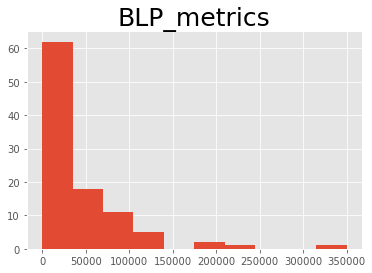

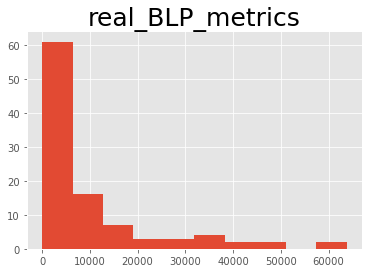

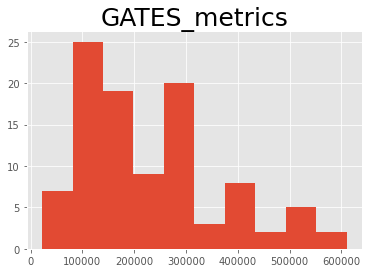

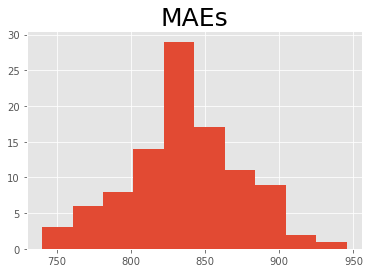

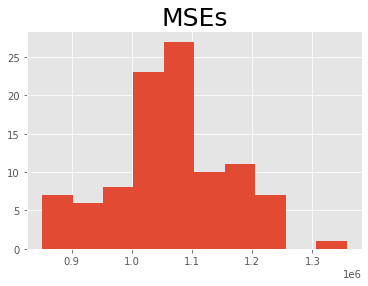

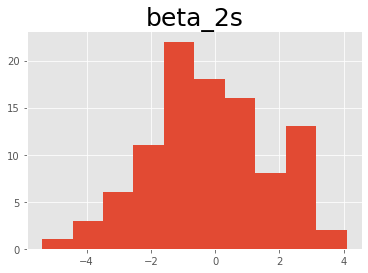

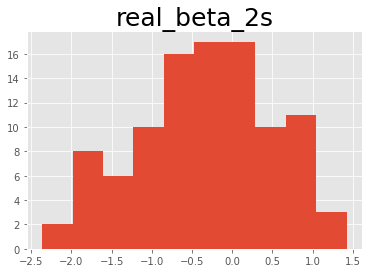

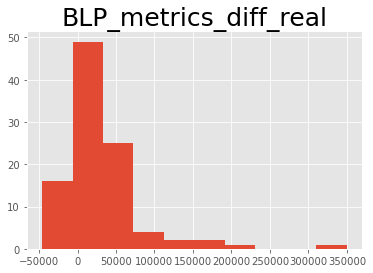

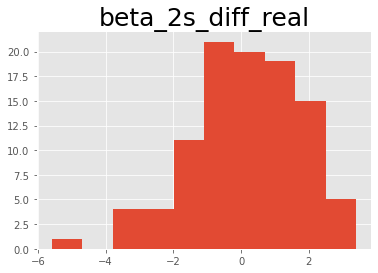

In [40]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:12<00:00,  7.92s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,53424.582790,233198.296140,829.270950,1.048029e+06,8296.034720,-0.240910,-0.245820
std,79122.957413,145207.790217,38.902455,9.281617e+04,12736.524424,1.927311,0.731138
min,3.385000,28667.005000,709.010000,7.758651e+05,0.319000,-5.282000,-2.083000
25%,4326.095250,137879.871250,806.340250,1.003377e+06,822.330750,-1.473750,-0.686500
50%,20698.411000,199581.971500,832.536000,1.046522e+06,3187.873000,-0.048000,-0.270500
75%,91436.296750,303126.555250,851.141500,1.100996e+06,9411.123000,1.008000,0.228500
max,506180.905000,905509.960000,928.297000,1.318659e+06,67612.902000,4.389000,1.522000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-218.126,-1576.112,1239.211,-1506.843,-1684.894,-1338.384
G2,-176.627,-1501.660,1249.422,-702.203,-794.006,-611.048
G3,-72.044,-1470.196,1254.869,-170.563,-257.892,-73.941
G4,-190.754,-1586.940,1200.670,392.642,305.838,487.682
G5,-214.411,-1629.300,1135.837,1296.251,997.212,1586.994


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-218.126,-1576.112,1239.211,-1506.843,-1684.894,-1338.384
x1,1.031,0.388,1.668,0.951,0.297,1.590
x4,9.286,7.686,10.910,8.996,7.120,10.800
x5,35.156,31.290,39.055,35.041,31.122,38.880
x6,-6.607,-9.888,-3.478,-5.763,-8.607,-2.892
...,...,...,...,...,...,...
x1270,-1.363,-2.894,0.198,-1.095,-2.823,0.673
x1271,0.342,-1.099,1.779,0.535,-0.964,2.044
x1272,1.727,0.014,3.338,1.899,0.022,3.697
x1273,0.215,-1.804,2.087,0.817,-1.064,2.750


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-214.411,-1629.300,1135.837,1296.251,997.212,1586.994
x1,1.033,0.390,1.659,1.323,0.714,1.930
x4,8.976,7.386,10.446,9.089,7.670,10.523
x5,34.515,30.839,38.304,35.609,31.665,39.192
x6,-6.262,-9.332,-3.035,-6.259,-9.362,-3.200
...,...,...,...,...,...,...
x1270,-1.033,-2.652,0.605,-1.645,-3.146,-0.103
x1271,0.720,-0.677,2.138,0.354,-1.132,1.910
x1272,2.004,0.367,3.579,1.825,0.206,3.472
x1273,0.412,-1.645,2.458,-0.230,-2.154,1.700


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,68.315,-2017.973,2044.606,2808.152,2460.365,3129.940
x1,-0.011,-0.889,0.874,0.377,-0.530,1.284
x4,-0.278,-2.552,1.932,0.147,-2.196,2.451
x5,-0.731,-6.137,4.453,0.510,-4.986,5.980
x6,0.322,-4.136,4.900,-0.465,-4.636,3.709
...,...,...,...,...,...,...
x1270,0.300,-2.044,2.552,-0.474,-2.730,1.848
x1271,0.357,-1.592,2.356,-0.192,-2.243,1.956
x1272,0.271,-2.006,2.670,0.048,-2.378,2.497
x1273,0.148,-2.816,3.091,-0.978,-3.616,1.772


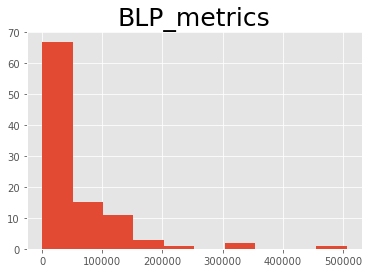

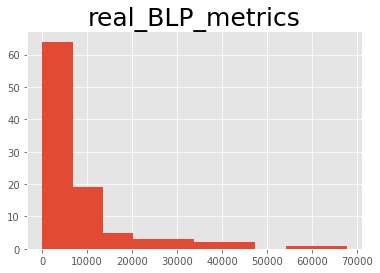

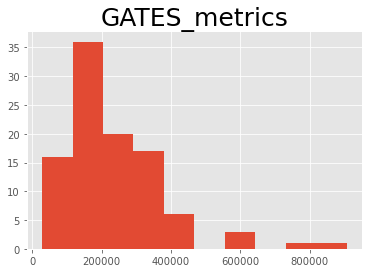

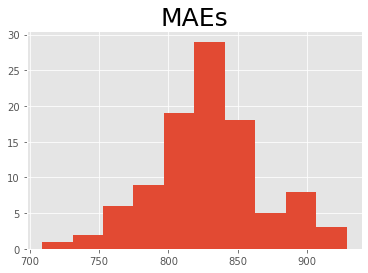

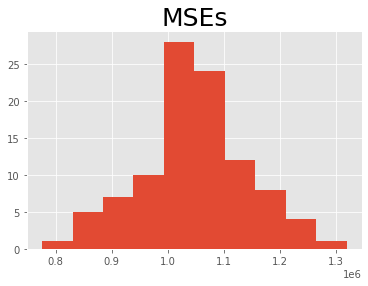

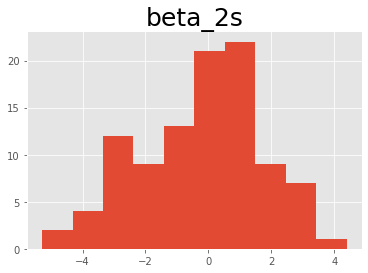

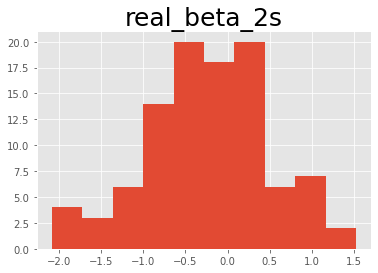

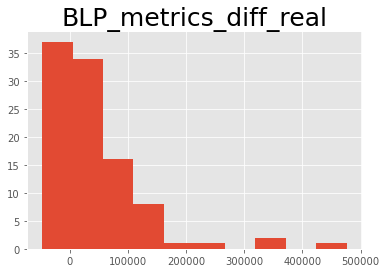

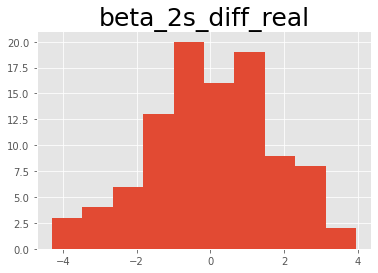

In [41]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:05<00:00,  9.66s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,42237.260910,234569.111180,852.287400,1.116387e+06,9477.402380,-0.142110,-0.110750
std,67028.353233,148797.368178,44.107564,1.131562e+05,12581.476328,0.953979,0.450612
min,12.526000,3449.077000,768.280000,8.945643e+05,3.682000,-2.971000,-1.582000
25%,2281.803250,121919.340000,817.984000,1.033764e+06,1159.898750,-0.607500,-0.345750
50%,15390.321000,205230.662000,847.656500,1.095679e+06,4204.629500,-0.038500,-0.137000
75%,49615.146750,312309.151000,873.294250,1.173452e+06,14064.121750,0.440750,0.195750
max,400043.253000,837970.269000,969.788000,1.471854e+06,60895.811000,2.087000,1.130000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-95.814,-1469.603,1294.963,-1511.060,-1684.551,-1328.838
G2,-129.625,-1493.719,1286.099,-696.027,-781.159,-604.241
G3,-112.005,-1465.562,1245.022,-156.434,-246.528,-64.302
G4,-125.139,-1488.491,1204.019,406.551,309.702,502.269
G5,-161.910,-1565.512,1213.705,1304.824,1002.825,1594.064


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-95.814,-1469.603,1294.963,-1511.060,-1684.551,-1328.838
x1,1.054,0.425,1.669,0.926,0.282,1.564
x4,8.989,7.456,10.511,8.951,7.201,10.695
x5,34.888,31.219,38.615,34.941,31.065,38.848
x6,-6.489,-9.717,-3.176,-5.955,-8.901,-3.051
...,...,...,...,...,...,...
x1270,-1.175,-2.782,0.404,-1.093,-2.856,0.659
x1271,0.454,-0.976,1.884,0.448,-1.078,1.968
x1272,1.643,-0.047,3.402,1.758,-0.090,3.612
x1273,0.168,-1.882,2.136,0.713,-1.273,2.697


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-161.910,-1565.512,1213.705,1304.824,1002.825,1594.064
x1,1.015,0.342,1.650,1.339,0.735,1.964
x4,8.995,7.413,10.638,9.152,7.689,10.542
x5,34.612,30.904,38.427,35.486,31.666,39.207
x6,-6.347,-9.480,-3.119,-6.315,-9.454,-3.086
...,...,...,...,...,...,...
x1270,-1.063,-2.601,0.602,-1.570,-3.091,0.010
x1271,0.591,-0.819,2.003,0.406,-1.097,1.981
x1272,1.928,0.371,3.477,1.799,0.223,3.482
x1273,0.395,-1.752,2.437,-0.117,-2.056,1.750


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-131.298,-2090.850,1883.974,2798.256,2468.403,3131.402
x1,-0.084,-0.989,0.820,0.470,-0.436,1.335
x4,0.013,-2.256,2.348,0.169,-2.085,2.498
x5,-0.199,-5.496,5.087,0.646,-4.985,6.028
x6,0.128,-4.461,4.747,-0.232,-4.524,3.918
...,...,...,...,...,...,...
x1270,0.187,-2.122,2.437,-0.435,-2.787,1.910
x1271,0.121,-1.835,2.223,0.007,-2.209,2.131
x1272,0.207,-2.043,2.480,-0.001,-2.415,2.444
x1273,0.220,-2.656,3.082,-0.858,-3.617,1.867


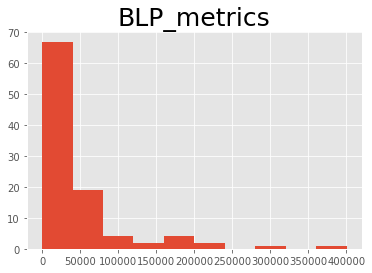

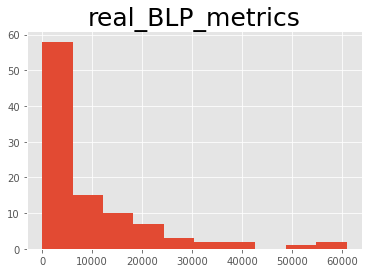

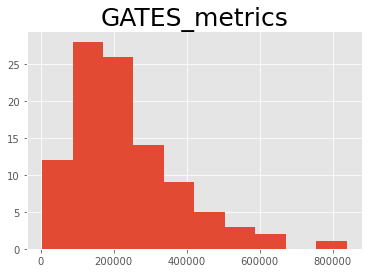

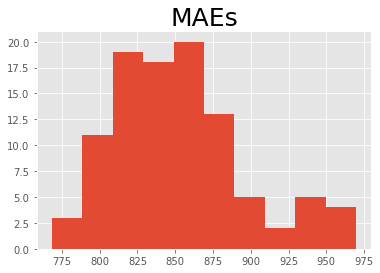

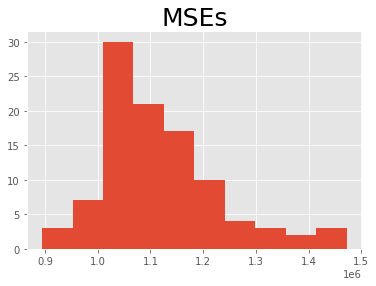

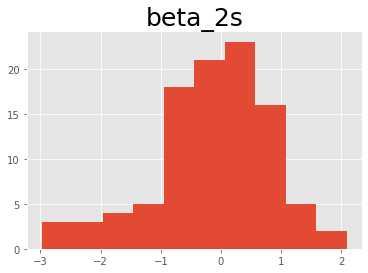

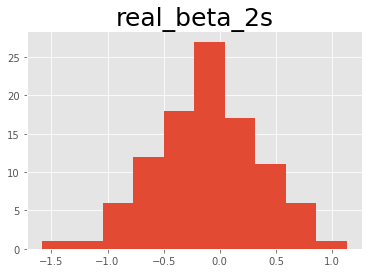

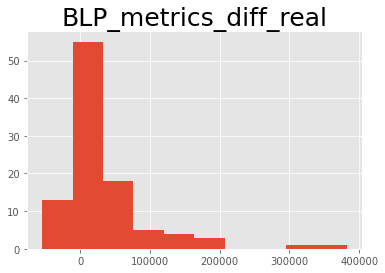

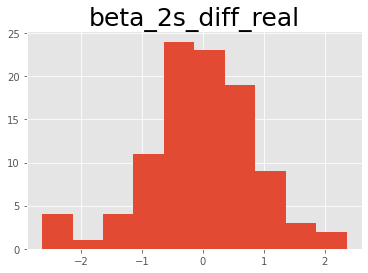

In [42]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = RandomForestRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### b) Tuning Elastic Net: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [43]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# elast0_tune_MSE = ElasticNet(alpha=0.1, 
#                           l1_ratio=1.0)

# elast1_tune_MSE = ElasticNet(alpha = 0.1, 
#                             l1_ratio = 1.0)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [44]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
elast0_tune_MSE1 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE2 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE3 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [45]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [elast0_tune_MSE1, elast0_tune_MSE2, elast0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+03, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.819e+03, tolerance: 3.771e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.336e+03, tolerance: 2.7

In [46]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    for l1_ratio in tqdm(np.linspace(0, 1, 11)):
        
        rf_sup = ElasticNet(alpha = alpha,
                                l1_ratio = l1_ratio)

        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                x_cols = x_cols, list_models0 = list_models0, 
                                                OOF0_samples = OOF0_samples, scalers0 = scalers0)
        if cur_lambda_hat > best_lambda_hat: 
            i += 1
            best_lambda_hat = cur_lambda_hat
            best_params['alpha'] = alpha
            best_params['l1_ratio'] = l1_ratio
            if i % 2 == 0:
                print(best_lambda_hat)
                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16488\2629798658.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):


  0%|          | 0/9 [00:00<?, ?it/s]


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-package

 45%|█████████████████████████████████████▋                                             | 5/11 [00:01<00:01,  3.63it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages

 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:02<00:00,  4.19it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages

178544.49154418393
{'alpha': 0.0001, 'l1_ratio': 0.0}


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+04, tolerance: 7.625e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+04, tolerance: 6.305e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e+04, tolerance: 6.9

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.792e+04, tolerance: 6.305e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+04, tolerance: 6.989e+03
  model = cd_fast.enet_coordinate_descent(

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:05<00:04,  1.17it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

 18%|███████████████                                                                    | 2/11 [00:01<00:07,  1.15it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+05, tolerance: 7.625e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+05, tolerance: 6.305e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:07<00:01,  1.20it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.388e+04, tolerance: 7.625e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+04, tolerance: 6.305e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+07, tolerance: 6.305e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+07, tolerance: 6.989e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mo

In [47]:
best_params, best_lambda_hat

({'alpha': 0.1, 'l1_ratio': 1.0}, 319134.1948693104)

In [48]:
elast1_tune_Lambda_hat = ElasticNet(alpha = best_params['alpha'] , 
                                   l1_ratio = best_params['l1_ratio'])

### General (non-pairwise) comparison of 3 ElasticNet specifications: target tuned, MSE tuned, default!!

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.626e+03, tolerance: 5.794e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.105e+04, tolerance: 1.054e+04
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<01:06,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 20%|████████████████▏                                                                | 20/100 [00:14<00:56,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.536e+03, tolerance: 5.729e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.076e+04, tolerance: 1.159e+04
  model = cd_fast.enet_coordinate_descent(
 21%|█████████████████                                                                | 21/100 [00:14<00:55,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 40%|████████████████████████████████▍                                                | 40/100 [00:28<00:44,  1.35it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+04, tolerance: 7.826e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.614e+04, tolerance: 8.609e+03
  model = cd_fast.enet_coordinate_descent(
 41%|█████████████████████████████████▏                                               | 41/100 [00:28<00:42,  1.39it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:42<00:27,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.953e+03, tolerance: 6.013e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+04, tolerance: 1.203e+04
  model = cd_fast.enet_coordinate_descent(
 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:43<00:26,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:57<00:14,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+04, tolerance: 7.609e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.580e+04, tolerance: 1.563e+04
  model = cd_fast.enet_coordinate_descent(
 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:57<00:13,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.00000,1.000000e+02,100.000000,100.000000,100.000000
mean,43559.344690,237066.654640,1071.64674,1.796144e+06,5874.165100,-0.124050,-0.033380
std,47805.247203,144808.832359,72.11614,2.268338e+05,8506.367317,0.226618,0.084921
min,1.847000,9693.511000,893.63800,1.284870e+06,0.084000,-0.544000,-0.291000
25%,6811.091000,125025.855250,1028.43225,1.634793e+06,752.328500,-0.282000,-0.095500
50%,27783.193500,208817.563500,1063.48800,1.777541e+06,2595.480500,-0.131500,-0.029000
75%,61241.016250,322588.714250,1119.63475,1.955925e+06,7100.895750,0.001250,0.035250
max,248099.206000,703837.487000,1230.66300,2.308137e+06,58551.171000,0.465000,0.131000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-15.149,-1380.908,1397.927,-1505.957,-1684.274,-1330.694
G2,-12.863,-1377.774,1327.227,-702.204,-798.065,-608.583
G3,-244.360,-1696.691,1148.596,-165.011,-257.781,-76.825
G4,-254.157,-1656.008,1117.924,393.413,297.741,479.921
G5,-253.358,-1644.578,1066.062,1270.574,996.778,1579.013


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-15.149,-1380.908,1397.927,-1505.957,-1684.274,-1330.694
x1,0.984,0.356,1.590,0.911,0.263,1.566
x4,9.135,7.580,10.687,8.965,7.143,10.734
x5,34.967,31.243,38.567,34.881,31.051,38.781
x6,-6.459,-9.577,-3.375,-5.984,-8.900,-2.894
...,...,...,...,...,...,...
x1270,-1.332,-2.873,0.240,-1.137,-2.914,0.610
x1271,0.362,-1.020,1.757,0.520,-0.940,2.015
x1272,1.632,-0.060,3.311,1.695,-0.113,3.519
x1273,0.253,-1.761,2.196,0.790,-1.081,2.682


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-253.358,-1644.578,1066.062,1270.574,996.778,1579.013
x1,1.000,0.358,1.630,1.345,0.711,1.937
x4,9.080,7.482,10.616,9.073,7.652,10.491
x5,34.767,31.017,38.451,35.307,31.508,39.102
x6,-6.084,-9.141,-3.020,-6.154,-9.258,-3.062
...,...,...,...,...,...,...
x1270,-1.055,-2.750,0.591,-1.536,-3.058,-0.081
x1271,0.571,-0.858,2.012,0.559,-0.984,2.008
x1272,1.882,0.330,3.441,1.852,0.283,3.438
x1273,0.229,-1.877,2.274,0.008,-1.903,1.911


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-300.160,-2231.018,1636.805,2783.570,2437.405,3125.719
x1,-0.005,-0.880,0.864,0.441,-0.464,1.304
x4,-0.051,-2.193,2.192,0.130,-2.167,2.378
x5,-0.159,-5.318,4.982,0.337,-5.091,5.788
x6,0.461,-4.035,5.045,-0.086,-4.406,4.113
...,...,...,...,...,...,...
x1270,0.125,-2.050,2.438,-0.454,-2.728,1.794
x1271,0.258,-1.753,2.361,0.075,-2.024,2.111
x1272,0.283,-1.988,2.592,0.151,-2.270,2.549
x1273,-0.051,-2.959,2.774,-0.822,-3.550,1.895


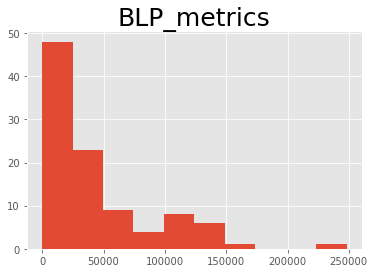

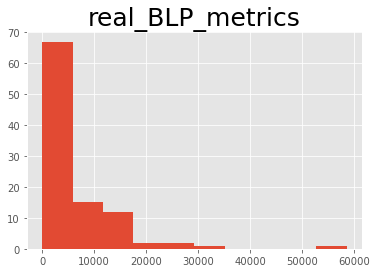

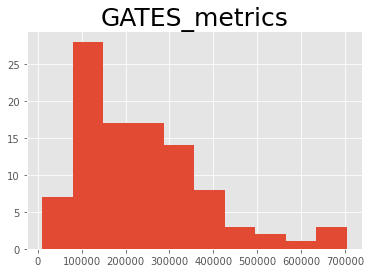

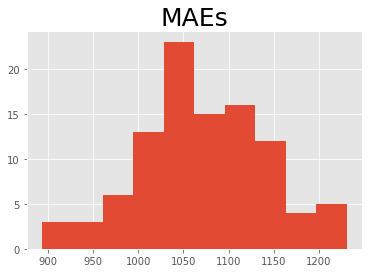

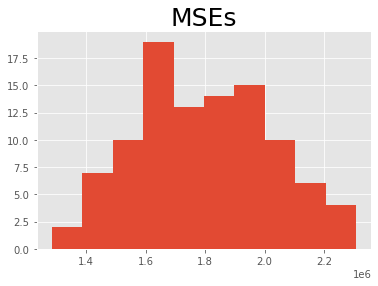

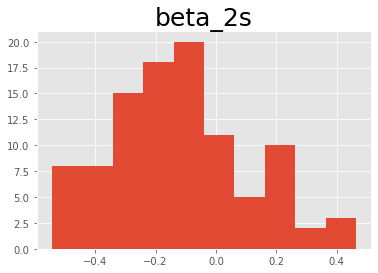

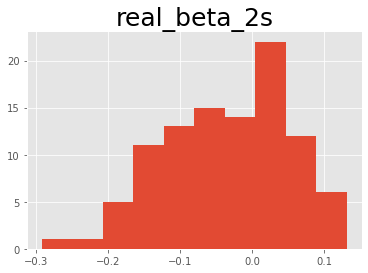

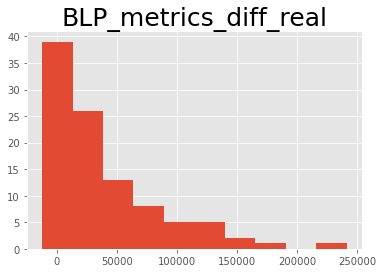

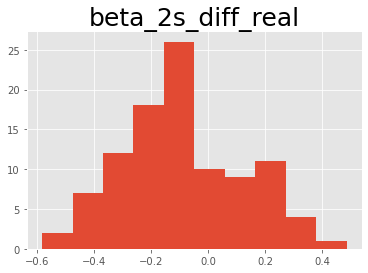

In [49]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+04, tolerance: 7.089e+03
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<01:00,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+04, tolerance: 6.624e+03
  model = cd_fast.enet_coordinate_descent(
  2%|█▋                                                       

 18%|██████████████▌                                                                  | 18/100 [00:13<00:59,  1.39it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+04, tolerance: 6.154e+03
  model = cd_fast.enet_coordinate_descent(
 19%|███████████████▍                                                                 | 19/100 [00:13<00:55,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e+04, tolerance: 6.874e+03
  model = cd_fast.enet_coordinate_descent(
 20%|████████████████▏                                        

 36%|█████████████████████████████▏                                                   | 36/100 [00:24<00:41,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+04, tolerance: 7.134e+03
  model = cd_fast.enet_coordinate_descent(
 37%|█████████████████████████████▉                                                   | 37/100 [00:25<00:39,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+04, tolerance: 7.253e+03
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████▊                          

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:37<00:36,  1.26it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+04, tolerance: 6.642e+03
  model = cd_fast.enet_coordinate_descent(
 55%|████████████████████████████████████████████▌                                    | 55/100 [00:38<00:37,  1.19it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e+04, tolerance: 8.374e+03
  model = cd_fast.enet_coordinate_descent(
 56%|█████████████████████████████████████████████▎           

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:50<00:18,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+04, tolerance: 8.056e+03
  model = cd_fast.enet_coordinate_descent(
 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:51<00:17,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+04, tolerance: 7.235e+03
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:02<00:06,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+04, tolerance: 6.203e+03
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:02<00:05,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+04, tolerance: 7.196e+03
  model = cd_fast.enet_coordinate_descent(
 92%|█████████████████████████████████████████████████████████

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.00000,100.000000,100.000000,1.000000e+02,100.00000,100.00000,100.00000
mean,95.52789,280879.195300,821.237010,1.036520e+06,106.55442,-456.85831,482.50539
std,955.27890,137010.871229,42.907172,1.058178e+05,1065.54420,4568.58310,4825.05390
min,0.00000,16500.452000,731.112000,8.091109e+05,0.00000,-45685.83100,-0.00000
25%,0.00000,187295.056750,785.468500,9.637752e+05,0.00000,-0.00000,0.00000
50%,0.00000,266286.253500,818.909500,1.026223e+06,0.00000,0.00000,0.00000
75%,0.00000,363088.509000,857.568000,1.097658e+06,0.00000,0.00000,0.00000
max,9552.78900,824119.695000,923.425000,1.351211e+06,10655.44200,-0.00000,48250.53900


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,509.482,-672.489,1647.138,-1494.418,-1678.431,-1315.747
G2,-107.571,-1420.971,1233.889,-684.299,-771.914,-595.300
G3,-58.682,-1631.879,1476.611,-153.654,-242.046,-62.872
G4,-474.407,-1772.617,847.246,396.483,312.546,489.862
G5,-501.952,-1994.338,975.148,1294.972,1009.304,1571.670


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,509.482,-672.489,1647.138,-1494.418,-1678.431,-1315.747
x1,1.114,0.523,1.700,0.944,0.291,1.581
x4,9.055,7.244,10.918,8.964,7.176,10.805
x5,34.590,30.295,39.177,34.767,30.879,38.696
x6,-6.060,-9.393,-2.776,-5.832,-8.750,-3.041
...,...,...,...,...,...,...
x1270,-0.869,-2.316,0.638,-1.130,-2.728,0.579
x1271,0.894,-0.620,2.322,0.452,-1.084,1.980
x1272,2.476,0.915,4.013,1.826,-0.010,3.662
x1273,1.050,-1.127,3.215,0.761,-1.143,2.672


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-501.952,-1994.338,975.148,1294.972,1009.304,1571.670
x1,1.062,0.452,1.671,1.313,0.719,1.898
x4,9.110,7.808,10.532,9.096,7.728,10.507
x5,34.782,30.984,38.627,35.523,31.890,39.202
x6,-5.997,-9.187,-2.728,-6.200,-9.347,-3.109
...,...,...,...,...,...,...
x1270,-1.302,-2.827,0.234,-1.557,-3.079,0.010
x1271,0.317,-1.102,1.727,0.405,-1.120,1.941
x1272,1.453,-0.158,3.159,1.935,0.342,3.527
x1273,-0.360,-2.520,1.837,-0.093,-2.056,1.776


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-1005.707,-2866.533,895.897,2782.618,2451.111,3138.029
x1,-0.053,-0.873,0.807,0.395,-0.479,1.275
x4,0.080,-2.171,2.356,0.203,-2.181,2.418
x5,0.107,-5.559,5.890,0.775,-4.769,6.022
x6,0.010,-4.501,4.577,-0.225,-4.557,4.026
...,...,...,...,...,...,...
x1270,-0.404,-2.539,1.741,-0.469,-2.697,1.864
x1271,-0.543,-2.621,1.472,-0.028,-2.177,2.083
x1272,-0.940,-3.186,1.281,0.050,-2.335,2.489
x1273,-1.356,-4.438,1.737,-0.822,-3.608,1.792


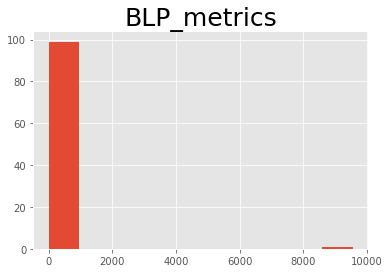

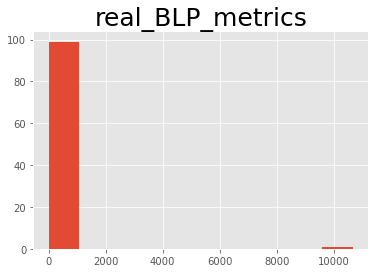

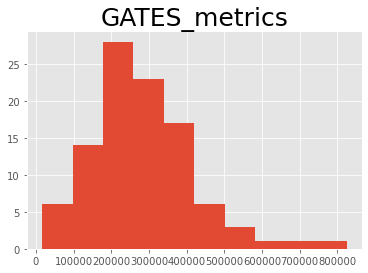

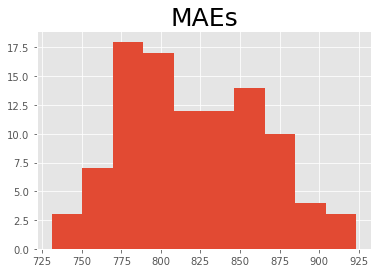

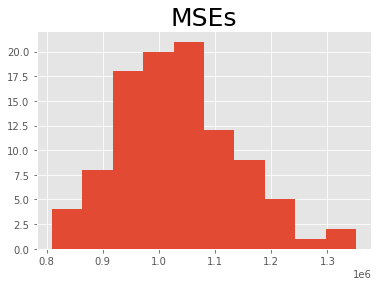

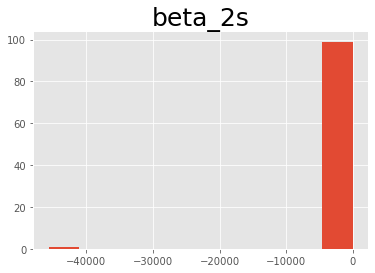

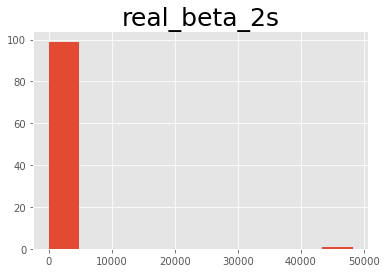

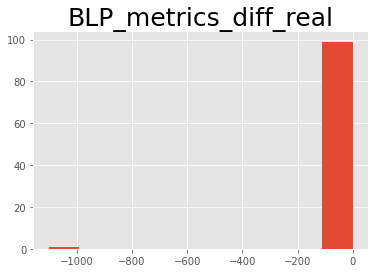

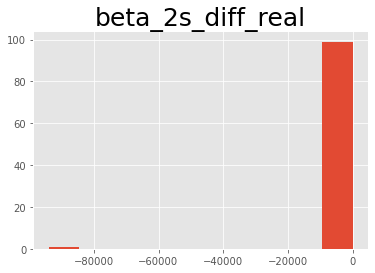

In [50]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.270e+03, tolerance: 5.634e+03
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<00:56,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+04, tolerance: 6.934e+03
  model = cd_fast.enet_coordinate_descent(
  2%|█▋                                                       

 18%|██████████████▌                                                                  | 18/100 [00:12<00:58,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+04, tolerance: 6.624e+03
  model = cd_fast.enet_coordinate_descent(
 19%|███████████████▍                                                                 | 19/100 [00:13<00:56,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+04, tolerance: 6.920e+03
  model = cd_fast.enet_coordinate_descent(
 20%|████████████████▏                                        

 36%|█████████████████████████████▏                                                   | 36/100 [00:24<00:44,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+04, tolerance: 6.585e+03
  model = cd_fast.enet_coordinate_descent(
 37%|█████████████████████████████▉                                                   | 37/100 [00:25<00:44,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+04, tolerance: 7.374e+03
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████▊                          

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:35<00:30,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+04, tolerance: 6.802e+03
  model = cd_fast.enet_coordinate_descent(
 55%|████████████████████████████████████████████▌                                    | 55/100 [00:36<00:31,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.321e+03, tolerance: 5.658e+03
  model = cd_fast.enet_coordinate_descent(
 56%|█████████████████████████████████████████████▎           

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:46<00:15,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e+04, tolerance: 7.331e+03
  model = cd_fast.enet_coordinate_descent(
 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:46<00:15,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.889e+03, tolerance: 6.037e+03
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:57<00:06,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+04, tolerance: 6.719e+03
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:58<00:05,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+04, tolerance: 7.504e+03
  model = cd_fast.enet_coordinate_descent(
 92%|█████████████████████████████████████████████████████████

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,31402.672990,217861.884990,869.920740,1.159067e+06,8382.514700,-0.096730,-0.154210
std,40786.820495,126095.378617,45.916498,1.153969e+05,11711.332336,0.605842,0.266613
min,0.156000,36340.185000,760.064000,8.911486e+05,3.212000,-1.771000,-0.762000
25%,2728.007000,131956.590250,839.177000,1.086015e+06,1008.071000,-0.581250,-0.336250
50%,15914.621000,184445.851500,871.485000,1.154556e+06,3199.857000,-0.090500,-0.143500
75%,41532.315500,283237.336750,900.680750,1.231613e+06,10675.039250,0.264250,0.032000
max,234633.698000,776351.269000,978.970000,1.465030e+06,57936.305000,1.371000,0.421000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,42.188,-1400.338,1417.252,-1493.743,-1665.624,-1321.052
G2,-46.472,-1474.780,1385.528,-700.838,-794.581,-608.273
G3,-133.225,-1517.531,1235.443,-171.386,-260.940,-76.441
G4,-352.302,-1652.373,1003.045,386.365,300.683,481.437
G5,-230.386,-1578.587,1156.459,1301.271,1002.937,1596.586


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,42.188,-1400.338,1417.252,-1493.743,-1665.624,-1321.052
x1,1.093,0.443,1.720,0.893,0.249,1.553
x4,9.171,7.477,10.859,8.869,7.175,10.664
x5,35.087,31.412,38.983,34.775,30.840,38.586
x6,-6.377,-9.629,-3.116,-6.048,-8.918,-3.214
...,...,...,...,...,...,...
x1270,-1.071,-2.543,0.360,-1.130,-2.878,0.605
x1271,0.290,-1.070,1.612,0.458,-1.030,1.952
x1272,1.848,0.212,3.501,1.846,0.061,3.626
x1273,-0.080,-2.046,1.896,0.748,-1.223,2.697


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-230.386,-1578.587,1156.459,1301.271,1002.937,1596.586
x1,0.935,0.316,1.570,1.311,0.697,1.931
x4,9.041,7.464,10.708,9.048,7.666,10.473
x5,34.332,30.415,38.260,35.385,31.719,39.071
x6,-6.426,-9.617,-3.100,-6.105,-9.274,-3.017
...,...,...,...,...,...,...
x1270,-0.881,-2.481,0.732,-1.440,-2.975,0.092
x1271,1.010,-0.468,2.505,0.424,-1.054,1.892
x1272,2.174,0.640,3.710,1.977,0.385,3.570
x1273,0.785,-1.379,3.037,-0.094,-1.931,1.777


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-161.455,-2173.576,1781.374,2797.541,2459.751,3146.425
x1,-0.103,-1.010,0.803,0.424,-0.479,1.314
x4,-0.211,-2.469,2.137,0.242,-2.005,2.416
x5,-0.965,-6.440,4.468,0.854,-4.525,6.079
x6,0.312,-4.375,4.815,-0.261,-4.447,3.941
...,...,...,...,...,...,...
x1270,0.129,-2.061,2.448,-0.417,-2.691,1.885
x1271,0.729,-1.301,2.739,-0.102,-2.205,2.003
x1272,0.284,-1.969,2.583,0.107,-2.222,2.551
x1273,1.037,-1.951,3.915,-0.838,-3.514,1.821


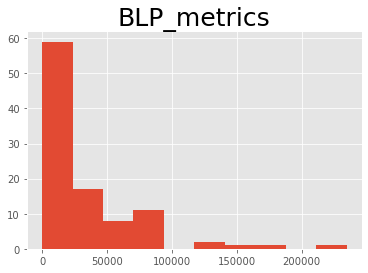

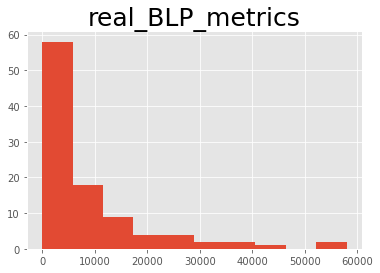

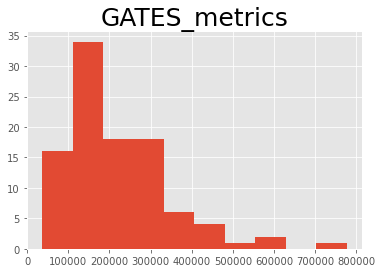

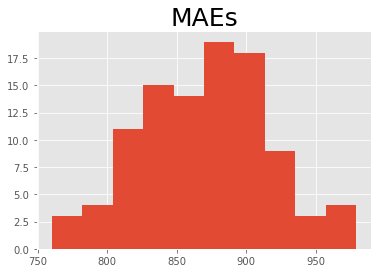

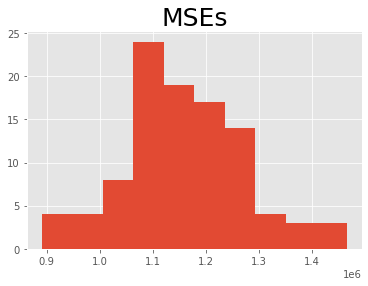

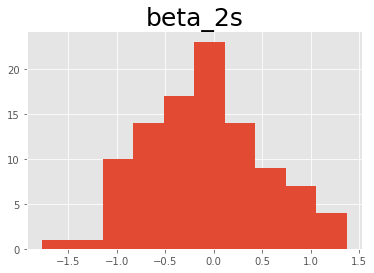

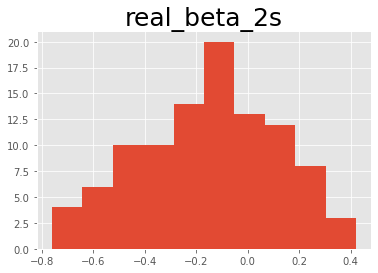

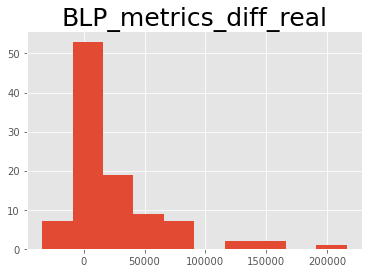

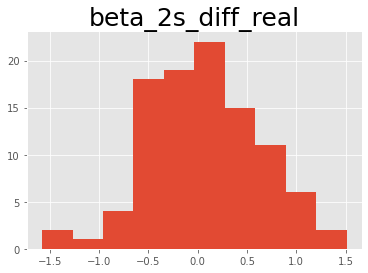

In [51]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = ElasticNet(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### c) Tuning Lgbm: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [52]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# lgbm0_tune_MSE = LGBMRegressor(colsample_bytree=1, 
#                                min_child_weight=0.0001, 
#                                min_split_gain=0,
#                                n_estimators=50, 
#                                num_leaves=20, 
#                                silent=False)

# lgbm1_tune_MSE = LGBMRegressor(colsample_bytree=0.8, 
#                                learning_rate=0.05, 
#                                min_child_weight=0.0001,
#                                min_split_gain=0,
#                                n_estimators=200, 
#                                num_leaves=20, 
#                                silent=False)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [53]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
lgbm0_tune_MSE1 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'],
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE2 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE3 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [54]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [lgbm0_tune_MSE1, lgbm0_tune_MSE2, lgbm0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 1264
[LightGBM] [Info] Start training from score -34.916072
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 1264
[LightGBM] [Info] Start training from score 53.101900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [55]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for colsample_bytree in tqdm_notebook([0.02, 0.05, 0.07, 0.1]):
    for learning_rate in tqdm([0.003, 0.005, 0.01, 0.03, 0.05, 0.07]):
        for num_leaves in tqdm([2, 3, 5]):
            for min_split_gain in [0, 0.0001]:
                for min_child_weight in [0, 0.0001, 0.01]:
                    for n_estimators in [2, 3]:
                        
                        rf_sup = LGBMRegressor(colsample_bytree = colsample_bytree, 
                                               learning_rate = learning_rate, 
                                               num_leaves = num_leaves, 
                                               min_split_gain = min_split_gain, 
                                               min_child_weight = min_child_weight, 
                                               n_estimators = n_estimators)

                        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                        
                        if cur_lambda_hat > best_lambda_hat: 
                            i += 1
                            best_lambda_hat = cur_lambda_hat
                            best_params['colsample_bytree'] = colsample_bytree
                            best_params['learning_rate'] = learning_rate
                            best_params['num_leaves'] = num_leaves
                            best_params['min_split_gain'] = min_split_gain
                            best_params['min_child_weight'] = min_child_weight
                            best_params['n_estimators'] = n_estimators
                            if i % 2 == 0:
                                print(best_lambda_hat)
                                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16488\3792495456.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for colsample_bytree in tqdm_notebook([0.02, 0.05, 0.07, 0.1]):


  0%|          | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.80s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:16<00:08,  8.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.00s/it]

 17%|██████████████                                                                      | 1/6 [00:24<02:00, 24.02s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.61s/it]

 67%|██████████████████████████

38270.66799708209
{'colsample_bytree': 0.02, 'learning_rate': 0.01, 'num_leaves': 2, 'min_split_gain': 0, 'min_child_weight': 0, 'n_estimators': 2}




 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.65s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.64s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:09<01:09, 23.15s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

105374.39017479122
{'colsample_bytree': 0.02, 'learning_rate': 0.03, 'num_leaves': 2, 'min_split_gain': 0, 'min_child_weight': 0, 'n_estimators': 2}




 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.67s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.66s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:32<00:46, 23.09s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

165990.7057832926
{'colsample_bytree': 0.02, 'learning_rate': 0.05, 'num_leaves': 2, 'min_split_gain': 0, 'min_child_weight': 0, 'n_estimators': 3}




 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.64s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.66s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:55<00:23, 23.05s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:07<00:15,  7.61s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.62s/it]

100%|█████████████████████████

In [56]:
best_params, best_lambda_hat

({'colsample_bytree': 0.02,
  'learning_rate': 0.07,
  'num_leaves': 2,
  'min_split_gain': 0,
  'min_child_weight': 0,
  'n_estimators': 3},
 174945.05116925164)

In [57]:
lgbm1_tune_Lambda_hat = LGBMRegressor(colsample_bytree = best_params['colsample_bytree'], 
                                               learning_rate = best_params['learning_rate'], 
                                               num_leaves = best_params['num_leaves'], 
                                               min_split_gain = best_params['min_split_gain'], 
                                               min_child_weight = best_params['min_child_weight'], 
                                               n_estimators = best_params['n_estimators'])

### General (non-pairwise) comparison of 3 lgbm specifications: target tuned, MSE tuned, default!!

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -60.037512


  1%|▊                                                                                 | 1/100 [00:00<01:02,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 214.807726


  2%|█▋                                                                                | 2/100 [00:01<01:00,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 17.333070


  3%|██▍                                                                               | 3/100 [00:01<01:00,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 107.395252


  4%|███▎                                                                              | 4/100 [00:02<01:00,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 11.569375


  5%|████                                                                              | 5/100 [00:03<00:59,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 213.258522


  6%|████▉                                                                             | 6/100 [00:03<00:58,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 82.011657


  7%|█████▋                                                                            | 7/100 [00:04<00:57,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 75.391137


  8%|██████▌                                                                           | 8/100 [00:04<00:56,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 84.880128


  9%|███████▍                                                                          | 9/100 [00:05<00:56,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 169.881793


 10%|████████                                                                         | 10/100 [00:06<00:56,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 60.579917


 11%|████████▉                                                                        | 11/100 [00:06<00:56,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 62.910222


 12%|█████████▋                                                                       | 12/100 [00:07<00:55,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 80.293369


 13%|██████████▌                                                                      | 13/100 [00:08<00:54,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 149.635964


 14%|███████████▎                                                                     | 14/100 [00:08<00:54,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 97.302096


 15%|████████████▏                                                                    | 15/100 [00:09<00:54,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 80.792585


 16%|████████████▉                                                                    | 16/100 [00:10<00:53,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 27.614017


 17%|█████████████▊                                                                   | 17/100 [00:10<00:52,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 142.912521


 18%|██████████████▌                                                                  | 18/100 [00:11<00:51,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 64.739903


 19%|███████████████▍                                                                 | 19/100 [00:11<00:51,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 93.860437


 20%|████████████████▏                                                                | 20/100 [00:12<00:49,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 52.044111


 21%|█████████████████                                                                | 21/100 [00:13<00:49,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 98.152665


 22%|█████████████████▊                                                               | 22/100 [00:13<00:48,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 58.465071


 23%|██████████████████▋                                                              | 23/100 [00:14<00:47,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -5.681592


 24%|███████████████████▍                                                             | 24/100 [00:15<00:47,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 131.497716


 25%|████████████████████▎                                                            | 25/100 [00:15<00:46,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 75.018678


 26%|█████████████████████                                                            | 26/100 [00:16<00:46,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -33.207113


 27%|█████████████████████▊                                                           | 27/100 [00:16<00:45,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 38.945074


 28%|██████████████████████▋                                                          | 28/100 [00:17<00:44,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -7.132927


 29%|███████████████████████▍                                                         | 29/100 [00:18<00:44,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -8.331087


 30%|████████████████████████▎                                                        | 30/100 [00:18<00:43,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 163.449162


 31%|█████████████████████████                                                        | 31/100 [00:19<00:42,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 61.299147


 32%|█████████████████████████▉                                                       | 32/100 [00:19<00:41,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 9.470901


 33%|██████████████████████████▋                                                      | 33/100 [00:20<00:41,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -13.568410


 34%|███████████████████████████▌                                                     | 34/100 [00:21<00:41,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 55.532891


 35%|████████████████████████████▎                                                    | 35/100 [00:22<00:43,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 175.071079


 36%|█████████████████████████████▏                                                   | 36/100 [00:22<00:41,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 132.240191


 37%|█████████████████████████████▉                                                   | 37/100 [00:23<00:40,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -19.324493


 38%|██████████████████████████████▊                                                  | 38/100 [00:23<00:39,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 119.190644


 39%|███████████████████████████████▌                                                 | 39/100 [00:24<00:37,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 50.684508


 40%|████████████████████████████████▍                                                | 40/100 [00:25<00:37,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 97.622144


 41%|█████████████████████████████████▏                                               | 41/100 [00:25<00:36,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 59.078226


 42%|██████████████████████████████████                                               | 42/100 [00:26<00:36,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 252.768300


 43%|██████████████████████████████████▊                                              | 43/100 [00:26<00:35,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 18.052656


 44%|███████████████████████████████████▋                                             | 44/100 [00:27<00:34,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 124.415531


 45%|████████████████████████████████████▍                                            | 45/100 [00:28<00:34,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 19.159944


 46%|█████████████████████████████████████▎                                           | 46/100 [00:28<00:33,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 11.305365


 47%|██████████████████████████████████████                                           | 47/100 [00:29<00:32,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 161.807235


 48%|██████████████████████████████████████▉                                          | 48/100 [00:30<00:31,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 20.358114


 49%|███████████████████████████████████████▋                                         | 49/100 [00:30<00:30,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 117.951144


 50%|████████████████████████████████████████▌                                        | 50/100 [00:31<00:30,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -24.084046


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:31<00:29,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 80.178964


 52%|██████████████████████████████████████████                                       | 52/100 [00:32<00:28,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -2.356283


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:32<00:27,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 131.405379


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:33<00:27,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 116.174619


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:34<00:26,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 232.245705


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:34<00:26,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -55.417940


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:35<00:25,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 92.796274


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:35<00:24,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 118.243968


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:36<00:24,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 33.802189


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:37<00:23,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 54.528721


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:23,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 40.826217


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:38<00:23,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 142.781173


 63%|███████████████████████████████████████████████████                              | 63/100 [00:38<00:22,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 61.312653


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:39<00:22,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 52.546611


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:40<00:21,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 214.607512


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:40<00:20,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 94.046312


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:41<00:20,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -15.123240


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:42<00:19,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 52.383921


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:42<00:19,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 101.885401


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:43<00:18,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 82.632064


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:43<00:17,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -21.343684


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:44<00:17,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 62.336453


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:45<00:16,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -46.599385


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:45<00:16,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 103.933800


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:46<00:15,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 103.224272


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:46<00:14,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 197.469876


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:47<00:14,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 59.141863


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:48<00:13,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -14.369918


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:48<00:12,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 171.273769


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:49<00:12,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 56.465376


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:50<00:11,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 155.493466


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:50<00:11,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 206.306114


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:51<00:10,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 86.584207


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:51<00:09,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 52.327425


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:52<00:09,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 100.056706


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:53<00:08,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 301.537692


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:53<00:08,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 101.346232


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:54<00:07,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 47.069224


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:55<00:06,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 136.795915


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:55<00:06,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 113.059992


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:56<00:05,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score -28.175230


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:56<00:04,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 140.429968


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:57<00:04,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 91.152205


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:58<00:03,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 25.797316


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:58<00:03,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 153.380954


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:59<00:02,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 152.097247


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:59<00:01,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 62.312264


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:00<00:01,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -101.213944


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:01<00:00,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -140.353063


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.00000,100.000000
mean,52475.502520,237142.411000,821.674050,1.034985e+06,7210.481540,-0.14721,-0.220070
std,62848.708757,129118.217026,42.727234,1.046596e+05,10222.129001,3.99541,1.521201
min,41.253000,54954.264000,702.795000,7.979503e+05,0.182000,-10.84000,-4.570000
25%,8205.520500,138131.118500,795.703500,9.708377e+05,655.315500,-3.07275,-1.128500
50%,29638.173000,208505.182500,825.309500,1.042881e+06,3464.955000,0.29950,-0.199000
75%,79216.850500,312875.637500,846.378000,1.089636e+06,9754.970500,2.74650,0.768250
max,292816.159000,682318.912000,908.835000,1.320540e+06,57672.649000,9.12400,3.443000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-6.467,-1478.745,1436.528,-1525.294,-1682.920,-1353.325
G2,-156.778,-1574.282,1184.532,-703.906,-800.494,-610.398
G3,-225.659,-1656.666,1183.860,-168.379,-261.110,-76.211
G4,-131.060,-1569.923,1174.891,393.012,301.977,485.046
G5,-118.295,-1513.176,1339.655,1291.631,1003.152,1577.636


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-6.467,-1478.745,1436.528,-1525.294,-1682.920,-1353.325
x1,1.064,0.452,1.694,0.904,0.260,1.546
x4,9.130,7.485,10.709,8.964,7.143,10.812
x5,34.830,30.883,38.693,34.941,31.030,38.682
x6,-6.141,-9.590,-3.051,-5.909,-8.759,-3.021
...,...,...,...,...,...,...
x1270,-0.976,-2.619,0.625,-0.983,-2.675,0.662
x1271,0.482,-0.942,2.016,0.459,-1.040,1.972
x1272,1.876,0.238,3.534,1.880,0.112,3.710
x1273,0.080,-1.981,2.178,0.716,-1.230,2.694


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-118.295,-1513.176,1339.655,1291.631,1003.152,1577.636
x1,0.999,0.340,1.627,1.362,0.747,1.957
x4,9.056,7.463,10.624,9.069,7.664,10.546
x5,34.762,31.176,38.446,35.612,31.787,39.075
x6,-6.261,-9.395,-3.012,-6.232,-9.246,-3.227
...,...,...,...,...,...,...
x1270,-1.162,-2.642,0.367,-1.544,-3.043,0.022
x1271,0.547,-0.805,1.984,0.341,-1.132,1.853
x1272,1.886,0.343,3.432,1.806,0.201,3.426
x1273,0.243,-1.782,2.353,-0.286,-2.144,1.638


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-68.280,-2039.315,1966.976,2823.124,2470.775,3165.997
x1,-0.067,-0.955,0.800,0.467,-0.428,1.352
x4,0.081,-2.164,2.308,0.151,-2.124,2.405
x5,-0.001,-5.397,5.642,0.415,-4.998,5.889
x6,0.164,-4.257,4.583,-0.382,-4.544,3.823
...,...,...,...,...,...,...
x1270,-0.094,-2.395,2.172,-0.443,-2.767,1.802
x1271,0.109,-1.906,2.177,-0.184,-2.270,2.026
x1272,0.023,-2.295,2.337,-0.046,-2.491,2.334
x1273,0.270,-2.572,3.154,-1.039,-3.737,1.665


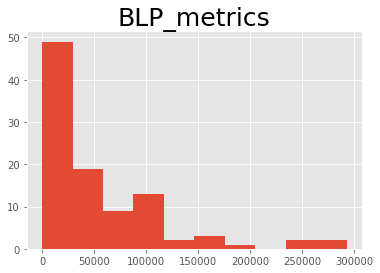

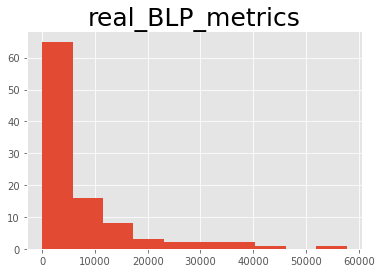

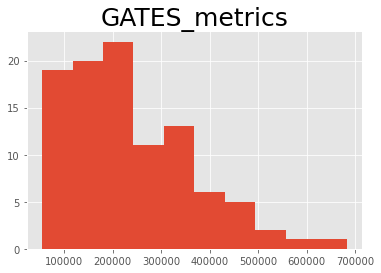

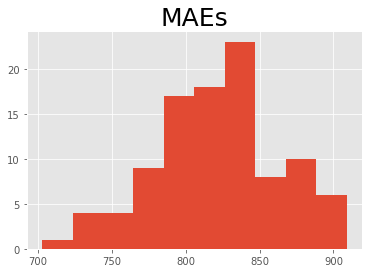

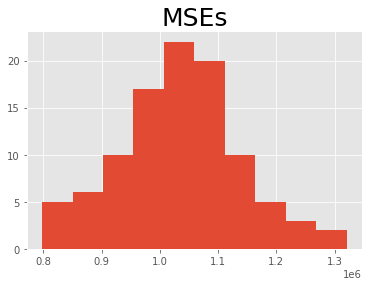

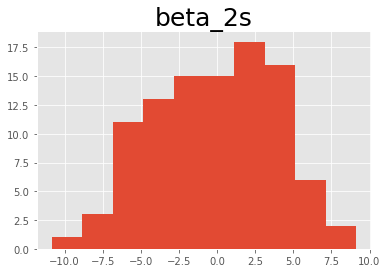

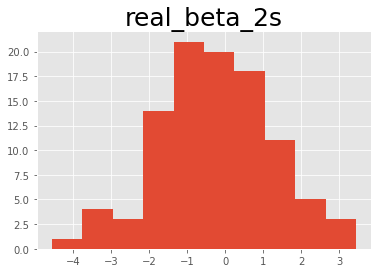

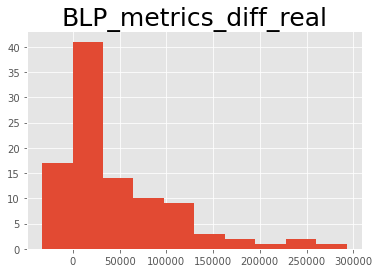

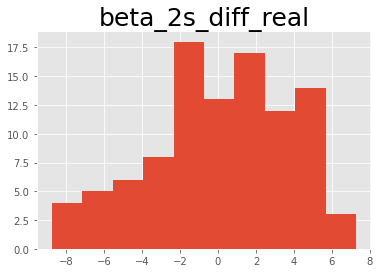

In [58]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -60.514765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -42.061251


  1%|▊                                                                                 | 1/100 [00:00<01:00,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 24.732396


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score 80.310833


  2%|█▋                                                                                | 2/100 [00:01<01:00,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 113.883590
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -132.916185


  3%|██▍                                                                               | 3/100 [00:01<01:01,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 103.144601


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 2.801116


  4%|███▎                                                                              | 4/100 [00:02<01:00,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 33.436607


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -328.466621


  5%|████                                                                              | 5/100 [00:03<01:00,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 162.993866


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -167.057069


  6%|████▉                                                                             | 6/100 [00:03<00:59,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -140.255522


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 72.151165


  7%|█████▋                                                                            | 7/100 [00:04<00:59,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 27.973012


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score -81.769200


  8%|██████▌                                                                           | 8/100 [00:05<00:57,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 31.621236
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -181.256401


  9%|███████▍                                                                          | 9/100 [00:05<00:56,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 43.734071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -535.460411


 10%|████████                                                                         | 10/100 [00:06<00:55,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 17.762432


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -224.207191


 11%|████████▉                                                                        | 11/100 [00:06<00:55,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 162.904966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -252.455455


 12%|█████████▋                                                                       | 12/100 [00:07<00:54,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 69.045364


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -313.973700


 13%|██████████▌                                                                      | 13/100 [00:08<00:53,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 73.712291
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score -232.735611


 14%|███████████▎                                                                     | 14/100 [00:08<00:52,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 8.152144


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -50.149554


 15%|████████████▏                                                                    | 15/100 [00:09<00:51,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 168.627325
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score 52.785170


 16%|████████████▉                                                                    | 16/100 [00:09<00:50,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 70.113833


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -16.901938


 17%|█████████████▊                                                                   | 17/100 [00:10<00:50,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 172.213276


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -384.972607


 18%|██████████████▌                                                                  | 18/100 [00:11<00:49,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 133.340166


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -281.662989


 19%|███████████████▍                                                                 | 19/100 [00:11<00:48,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 96.522750
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -68.033175


 20%|████████████████▏                                                                | 20/100 [00:12<00:48,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 80.565721


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score 24.354457


 21%|█████████████████                                                                | 21/100 [00:12<00:47,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -27.466042


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 165.597588


 22%|█████████████████▊                                                               | 22/100 [00:13<00:49,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 97.809056
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -339.233664


 23%|██████████████████▋                                                              | 23/100 [00:14<00:49,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 146.558047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -321.143617


 24%|███████████████████▍                                                             | 24/100 [00:14<00:47,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 91.650550


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -177.270377


 25%|████████████████████▎                                                            | 25/100 [00:15<00:46,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score 136.913815
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score -310.894915


 26%|█████████████████████                                                            | 26/100 [00:16<00:45,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 110.202298
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -465.215537


 27%|█████████████████████▊                                                           | 27/100 [00:16<00:45,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 83.059019


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -104.566536


 28%|██████████████████████▋                                                          | 28/100 [00:17<00:44,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -20.661376


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 42.515561


 29%|███████████████████████▍                                                         | 29/100 [00:17<00:43,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 58.634732
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -171.653840


 30%|████████████████████████▎                                                        | 30/100 [00:18<00:42,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 106.169087


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -57.569551


 31%|█████████████████████████                                                        | 31/100 [00:19<00:41,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 123.031355
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -36.311427


 32%|█████████████████████████▉                                                       | 32/100 [00:19<00:41,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 79.928620
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -108.429680


 33%|██████████████████████████▋                                                      | 33/100 [00:20<00:40,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 173.928418
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -224.180799


 34%|███████████████████████████▌                                                     | 34/100 [00:20<00:39,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 74.535976


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -67.464498


 35%|████████████████████████████▎                                                    | 35/100 [00:21<00:41,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -29.919645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -241.405114


 36%|█████████████████████████████▏                                                   | 36/100 [00:22<00:39,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 64.367034


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -161.792887


 37%|█████████████████████████████▉                                                   | 37/100 [00:22<00:39,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 17.875915


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 42.599010


 38%|██████████████████████████████▊                                                  | 38/100 [00:23<00:38,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 174.284311


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -217.207134


 39%|███████████████████████████████▌                                                 | 39/100 [00:24<00:37,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 150.112465


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -362.612080


 40%|████████████████████████████████▍                                                | 40/100 [00:24<00:37,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 70.045159


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -420.457064


 41%|█████████████████████████████████▏                                               | 41/100 [00:25<00:36,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 151.971363


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -166.308881


 42%|██████████████████████████████████                                               | 42/100 [00:25<00:36,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 243.174410


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -86.280447


 43%|██████████████████████████████████▊                                              | 43/100 [00:26<00:35,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 77.388896


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -15.676633


 44%|███████████████████████████████████▋                                             | 44/100 [00:27<00:34,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 110.886575


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -239.678104


 45%|████████████████████████████████████▍                                            | 45/100 [00:27<00:34,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 63.417458


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 13.061460


 46%|█████████████████████████████████████▎                                           | 46/100 [00:28<00:33,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -17.154968


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -157.079371


 47%|██████████████████████████████████████                                           | 47/100 [00:29<00:32,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 78.286865


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 59.682768


 48%|██████████████████████████████████████▉                                          | 48/100 [00:29<00:31,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -54.939367


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 15.493299


 49%|███████████████████████████████████████▋                                         | 49/100 [00:30<00:31,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 120.724061


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -141.989094


 50%|████████████████████████████████████████▌                                        | 50/100 [00:30<00:30,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 180.282415


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -315.966135


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:31<00:30,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 71, number of used features: 1264
[LightGBM] [Info] Start training from score 196.269877


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 1264
[LightGBM] [Info] Start training from score -145.789597


 52%|██████████████████████████████████████████                                       | 52/100 [00:32<00:29,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 40.681810


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -101.901809


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:32<00:28,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -13.556559


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -181.088059


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:33<00:28,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 40.815755


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 25.862226


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:33<00:27,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 248.799497
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -93.629904


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:34<00:26,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 30.225674
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -82.376874


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:35<00:26,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 67.191607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 126.995802


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:35<00:25,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 155.901674


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -25.980729


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:36<00:24,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 126.539253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004083 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -73.599921


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:36<00:24,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 136.200341


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 1264
[LightGBM] [Info] Start training from score 5.248742


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:23,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 120.913020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -441.057146


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:38<00:22,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 81.013745


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -215.145484


 63%|███████████████████████████████████████████████████                              | 63/100 [00:38<00:22,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 178.432748


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -444.718813


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:39<00:21,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 194.403114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004070 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -127.464430


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:39<00:20,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 141.107383
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -18.188672


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:40<00:20,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 68.796619


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -102.232507


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:41<00:19,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 97.596176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -61.636512


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:41<00:19,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 120.719546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -133.890552


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:42<00:18,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 308.071032
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -427.666924


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:42<00:18,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 46.180405


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -22.689322


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:43<00:17,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 42.385966


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 260.611180


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:44<00:17,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 131.689815
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -255.749598


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:44<00:16,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 168.615281


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -173.233998


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:45<00:15,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 63.696605
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -372.797638


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:45<00:15,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 69.550365


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -233.469945


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:46<00:14,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 137.575786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -325.267213


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:47<00:13,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -53.415889
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -115.241639


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:47<00:13,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 101.124214
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score -9.981633


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:48<00:12,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 135.187358


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -196.068167


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:49<00:12,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score 183.987283


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 1264
[LightGBM] [Info] Start training from score -192.677513


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:49<00:11,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 207.038025


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -340.221834


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:50<00:11,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 202.565492


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -377.117832


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:50<00:10,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 13.544394
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 126.435707


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:51<00:09,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 24.803569
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -76.464209


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:52<00:09,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 164.721216
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score -192.506155


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:52<00:09,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 99.639827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -124.216901


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:53<00:08,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 58.407238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -166.048006


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:54<00:07,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 81.676048


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -377.816580


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:54<00:06,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 173.120786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -293.989006


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:55<00:06,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40448
[LightGBM] [Info] Number of data points in the train set: 92, number of used features: 1264
[LightGBM] [Info] Start training from score 15.833659


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18960
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 1264
[LightGBM] [Info] Start training from score -217.858850


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:55<00:05,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -73.564707


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -79.352510


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:56<00:04,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -77.622642


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -88.191893


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:57<00:04,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 185.845181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006287 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -313.645833


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:57<00:03,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 176.640260


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 1264
[LightGBM] [Info] Start training from score -256.103761


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:58<00:03,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 55.362193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -48.893829


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:58<00:02,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 104.694445


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -41.459750


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:59<00:01,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 62.120677


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -160.218504


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:00<00:01,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 29.239126


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -112.865777


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:00<00:00,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 86.889592
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -135.678584


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.00000,100.000000,100.000000
mean,45743.108430,226120.579370,818.670790,1.027465e+06,6475.55236,27.412430,6.483970
std,56341.882441,136272.483158,40.337773,9.712695e+04,8052.29725,103.655668,39.582863
min,5.275000,13443.116000,731.334000,7.911357e+05,0.19200,-182.186000,-80.312000
25%,3929.521500,128504.416250,796.489000,9.560677e+05,824.41275,-39.837750,-23.871750
50%,24272.432500,209651.650000,814.648000,1.028198e+06,3421.55000,17.162500,7.563000
75%,68821.892500,282989.719750,836.979000,1.077287e+06,9029.37075,99.828000,33.275250
max,337644.408000,742565.290000,921.128000,1.302051e+06,41863.93200,288.494000,102.788000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-214.496,-1634.525,1176.267,-1522.464,-1700.624,-1342.879
G2,-130.186,-1532.542,1266.261,-708.352,-802.977,-616.835
G3,-228.244,-1639.633,1197.439,-173.309,-261.296,-84.841
G4,-106.898,-1500.264,1255.777,387.421,296.855,477.963
G5,-57.618,-1454.361,1328.511,1274.084,992.354,1562.772


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-214.496,-1634.525,1176.267,-1522.464,-1700.624,-1342.879
x1,1.084,0.468,1.675,0.892,0.255,1.521
x4,8.937,7.396,10.511,8.991,7.076,10.723
x5,34.736,30.800,38.490,34.752,30.821,38.645
x6,-6.225,-9.400,-3.086,-5.931,-8.893,-3.047
...,...,...,...,...,...,...
x1270,-0.988,-2.699,0.589,-1.115,-2.770,0.686
x1271,0.371,-1.074,1.757,0.572,-0.933,2.036
x1272,1.787,0.107,3.484,1.752,-0.012,3.547
x1273,-0.009,-1.969,1.951,0.737,-1.046,2.637


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-57.618,-1454.361,1328.511,1274.084,992.354,1562.772
x1,1.008,0.378,1.644,1.359,0.754,1.938
x4,9.093,7.532,10.591,9.117,7.704,10.485
x5,34.634,30.897,38.447,35.341,31.578,39.203
x6,-6.312,-9.440,-3.143,-6.197,-9.195,-3.116
...,...,...,...,...,...,...
x1270,-1.067,-2.616,0.536,-1.472,-3.015,0.081
x1271,0.476,-0.914,1.945,0.403,-1.070,1.909
x1272,1.921,0.346,3.471,1.896,0.262,3.488
x1273,0.386,-1.660,2.405,-0.122,-2.122,1.872


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,194.230,-1801.957,2156.580,2794.191,2445.120,3124.451
x1,-0.015,-0.875,0.855,0.428,-0.440,1.296
x4,0.240,-2.052,2.373,0.158,-2.114,2.469
x5,-0.118,-5.500,5.549,0.703,-4.628,5.960
x6,-0.091,-4.599,4.384,-0.327,-4.511,3.880
...,...,...,...,...,...,...
x1270,-0.003,-2.224,2.255,-0.431,-2.661,1.838
x1271,0.196,-1.927,2.135,-0.123,-2.170,2.007
x1272,0.208,-2.108,2.531,-0.003,-2.326,2.447
x1273,0.373,-2.462,3.305,-0.866,-3.592,1.862


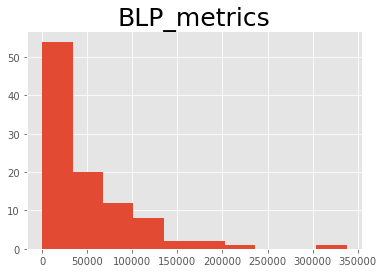

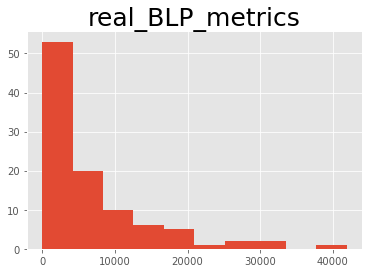

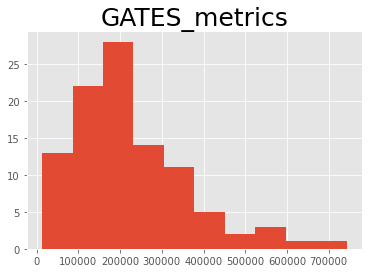

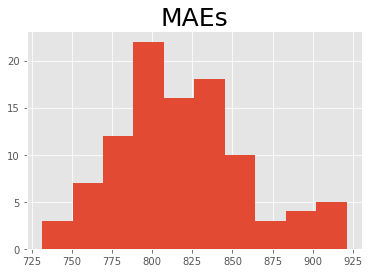

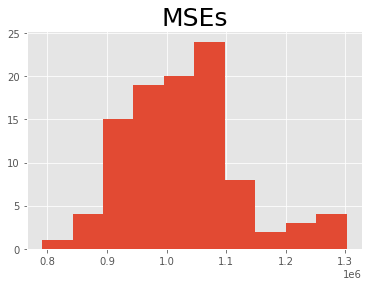

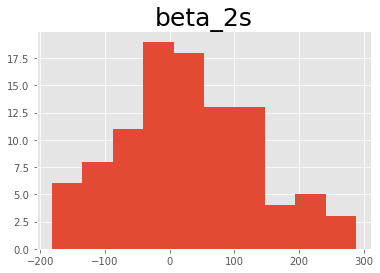

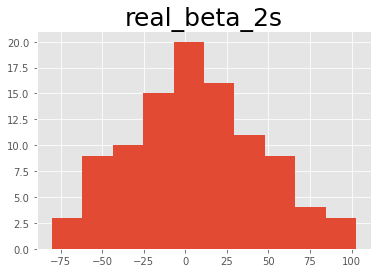

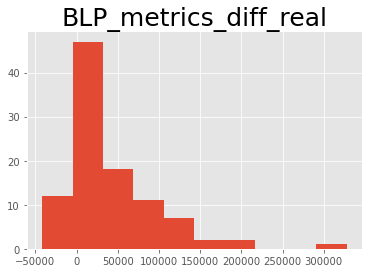

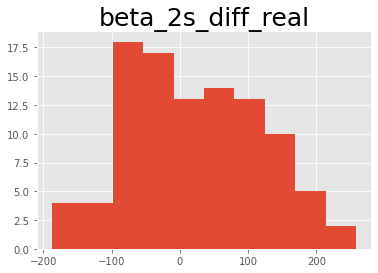

In [59]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 76.889680


  1%|▊                                                                                 | 1/100 [00:00<01:06,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 88.352609


  2%|█▋                                                                                | 2/100 [00:01<01:05,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 90.340788


  3%|██▍                                                                               | 3/100 [00:02<01:06,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 146.265245


  4%|███▎                                                                              | 4/100 [00:02<01:05,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 29.888158


  5%|████                                                                              | 5/100 [00:03<01:05,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 42.698213


  6%|████▉                                                                             | 6/100 [00:04<01:04,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 68.288875


  7%|█████▋                                                                            | 7/100 [00:04<01:03,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 117.378104


  8%|██████▌                                                                           | 8/100 [00:05<01:03,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 65.927685


  9%|███████▍                                                                          | 9/100 [00:06<01:02,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 204.001925


 10%|████████                                                                         | 10/100 [00:06<01:01,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 99.191806


 11%|████████▉                                                                        | 11/100 [00:07<01:00,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 61.272616


 12%|█████████▋                                                                       | 12/100 [00:08<00:59,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 262.989400


 13%|██████████▌                                                                      | 13/100 [00:08<00:58,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 116.007945


 14%|███████████▎                                                                     | 14/100 [00:09<00:57,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 88.257907


 15%|████████████▏                                                                    | 15/100 [00:10<00:56,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 93.301220


 16%|████████████▉                                                                    | 16/100 [00:10<00:55,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 26.749428


 17%|█████████████▊                                                                   | 17/100 [00:11<00:55,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 31.194908


 18%|██████████████▌                                                                  | 18/100 [00:12<00:55,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 0.823651


 19%|███████████████▍                                                                 | 19/100 [00:12<00:55,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 84.217770


 20%|████████████████▏                                                                | 20/100 [00:13<00:54,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score 94.019039


 21%|█████████████████                                                                | 21/100 [00:14<00:54,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -6.931081


 22%|█████████████████▊                                                               | 22/100 [00:14<00:52,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 33.489316


 23%|██████████████████▋                                                              | 23/100 [00:15<00:51,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 44.389175


 24%|███████████████████▍                                                             | 24/100 [00:16<00:51,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 199.382290


 25%|████████████████████▎                                                            | 25/100 [00:16<00:50,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 200.917487


 26%|█████████████████████                                                            | 26/100 [00:17<00:50,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 126.141436


 27%|█████████████████████▊                                                           | 27/100 [00:18<00:49,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -14.167156


 28%|██████████████████████▋                                                          | 28/100 [00:19<00:49,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 111.074340


 29%|███████████████████████▍                                                         | 29/100 [00:19<00:48,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 88.738165


 30%|████████████████████████▎                                                        | 30/100 [00:20<00:47,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 89.750874


 31%|█████████████████████████                                                        | 31/100 [00:21<00:48,  1.43it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 189.892859


 32%|█████████████████████████▉                                                       | 32/100 [00:21<00:49,  1.38it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 109.924770


 33%|██████████████████████████▋                                                      | 33/100 [00:22<00:46,  1.43it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 130.497457


 34%|███████████████████████████▌                                                     | 34/100 [00:23<00:45,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 82.548116


 35%|████████████████████████████▎                                                    | 35/100 [00:23<00:44,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 75.850299


 36%|█████████████████████████████▏                                                   | 36/100 [00:24<00:43,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 141.500384


 37%|█████████████████████████████▉                                                   | 37/100 [00:25<00:41,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 218.747496


 38%|██████████████████████████████▊                                                  | 38/100 [00:25<00:41,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 126.657947


 39%|███████████████████████████████▌                                                 | 39/100 [00:26<00:46,  1.30it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 40.448792


 40%|████████████████████████████████▍                                                | 40/100 [00:27<00:46,  1.28it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -5.645212


 41%|█████████████████████████████████▏                                               | 41/100 [00:28<00:44,  1.33it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 47.062052


 42%|██████████████████████████████████                                               | 42/100 [00:29<00:42,  1.37it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 49.979736


 43%|██████████████████████████████████▊                                              | 43/100 [00:29<00:41,  1.39it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -8.094006


 44%|███████████████████████████████████▋                                             | 44/100 [00:30<00:39,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 105.174322


 45%|████████████████████████████████████▍                                            | 45/100 [00:31<00:38,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 98.355456


 46%|█████████████████████████████████████▎                                           | 46/100 [00:31<00:37,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 39.611294


 47%|██████████████████████████████████████                                           | 47/100 [00:32<00:36,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 59.874154


 48%|██████████████████████████████████████▉                                          | 48/100 [00:33<00:35,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 54.833438


 49%|███████████████████████████████████████▋                                         | 49/100 [00:33<00:35,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 38.075920


 50%|████████████████████████████████████████▌                                        | 50/100 [00:34<00:34,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 54.816939


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:35<00:33,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 173.190973


 52%|██████████████████████████████████████████                                       | 52/100 [00:35<00:32,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 125.316622


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:36<00:31,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 90.479653


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:37<00:31,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 93.028372


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:37<00:30,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 57.275511


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:38<00:29,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 30.761930


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:39<00:28,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -85.004806


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:39<00:27,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 197.583836


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:40<00:26,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 195.019265


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:41<00:26,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -25.066575


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:41<00:26,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 134.572899


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:42<00:25,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 36.421988


 63%|███████████████████████████████████████████████████                              | 63/100 [00:43<00:24,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 175.500440


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:43<00:24,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 84.636504


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:44<00:23,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 60.430913


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:45<00:23,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -25.385126


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:45<00:22,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 89.197837


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:46<00:21,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 159.736124


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:47<00:21,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 208.170209


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:47<00:20,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score 98.401848


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:48<00:20,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 20.712906


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:49<00:19,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score 84.917321


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:50<00:18,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 21.354202


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:50<00:17,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 93.865533


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:51<00:17,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 198.201318


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:52<00:17,  1.35it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40448
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 1264
[LightGBM] [Info] Start training from score 97.908493


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:52<00:16,  1.39it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 141.309384


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:53<00:15,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 83.242331


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:54<00:14,  1.40it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 148.558560


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:55<00:14,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 150.349245


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:55<00:13,  1.43it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 94.934605


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:56<00:12,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 75.393812


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:57<00:11,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 117.847453


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:57<00:11,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 93.910216


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:58<00:10,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 159.559992


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:59<00:09,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 58.608056


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:59<00:08,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 70.020937


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:00<00:08,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 17.326695


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:01<00:07,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 150.671511


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:01<00:06,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 143.090448


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:02<00:06,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 34.148699


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:03<00:05,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 233.944563


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:03<00:04,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 75.341732


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:04<00:04,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 44.218074


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:05<00:03,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 55.547245


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:05<00:02,  1.48it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -1.920528


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:06<00:02,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 116.242067


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:07<00:01,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 116.932890


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:07<00:00,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 133.526093


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,38876.403240,212760.657710,953.724710,1.395154e+06,7294.235330,-0.096530,-0.015210
std,56044.446749,126986.685211,47.510113,1.152129e+05,8377.319911,0.338949,0.149635
min,11.050000,23844.441000,824.935000,1.114739e+06,2.911000,-0.939000,-0.323000
25%,2809.708500,116243.532000,924.026250,1.317081e+06,771.506500,-0.280000,-0.125500
50%,14794.427000,191735.626500,955.917000,1.403899e+06,4300.848500,-0.083500,-0.027500
75%,42335.340000,280348.181750,982.405500,1.466990e+06,10773.202500,0.119750,0.084750
max,236780.855000,575886.720000,1049.578000,1.714479e+06,36368.395000,0.760000,0.349000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-128.367,-1459.885,1261.923,-1509.864,-1683.264,-1330.647
G2,-36.727,-1438.773,1297.137,-691.335,-794.128,-601.617
G3,-156.343,-1558.449,1233.851,-154.503,-247.063,-58.914
G4,-133.056,-1599.213,1286.295,399.754,319.226,491.436
G5,-192.474,-1651.164,1182.188,1302.296,1002.678,1588.215


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-128.367,-1459.885,1261.923,-1509.864,-1683.264,-1330.647
x1,1.055,0.413,1.676,0.918,0.276,1.578
x4,8.937,7.345,10.542,8.969,7.228,10.743
x5,34.698,31.045,38.546,34.963,31.160,38.799
x6,-6.425,-9.539,-3.205,-5.802,-8.823,-2.997
...,...,...,...,...,...,...
x1270,-1.226,-2.847,0.290,-1.094,-2.829,0.662
x1271,0.356,-1.101,1.852,0.443,-1.086,1.947
x1272,1.672,0.017,3.265,1.782,-0.064,3.609
x1273,0.012,-1.987,2.028,0.760,-1.214,2.697


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-192.474,-1651.164,1182.188,1302.296,1002.678,1588.215
x1,0.927,0.331,1.556,1.337,0.716,1.942
x4,9.125,7.617,10.629,9.079,7.701,10.485
x5,34.918,31.309,38.513,35.579,31.869,39.117
x6,-5.959,-9.108,-2.926,-6.032,-9.033,-2.954
...,...,...,...,...,...,...
x1270,-1.068,-2.653,0.530,-1.531,-3.064,0.029
x1271,0.555,-0.817,1.985,0.402,-1.067,1.898
x1272,1.887,0.279,3.377,1.880,0.233,3.482
x1273,0.224,-1.913,2.302,-0.095,-2.043,1.809


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-117.211,-2055.023,1852.214,2809.147,2468.019,3150.486
x1,-0.084,-0.970,0.811,0.427,-0.441,1.271
x4,0.160,-2.031,2.302,0.094,-2.141,2.367
x5,0.026,-5.264,5.101,0.427,-4.914,6.035
x6,0.275,-3.982,4.735,-0.129,-4.287,4.023
...,...,...,...,...,...,...
x1270,0.144,-2.071,2.361,-0.392,-2.683,1.929
x1271,0.230,-1.782,2.282,0.040,-2.096,2.186
x1272,0.186,-2.118,2.556,0.088,-2.340,2.505
x1273,0.162,-2.775,3.097,-0.884,-3.672,1.885


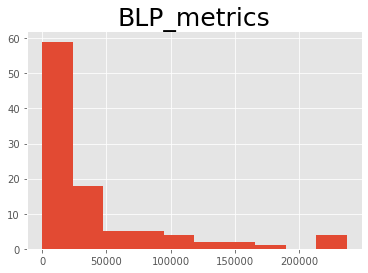

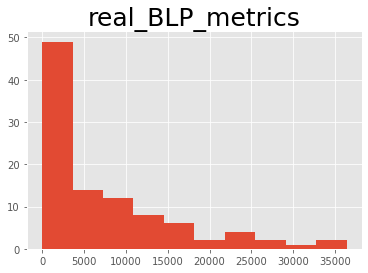

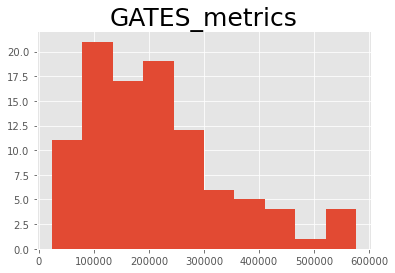

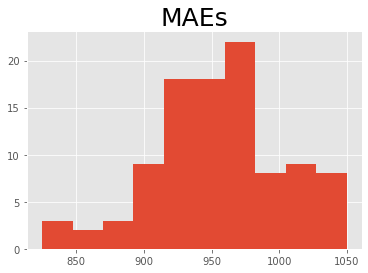

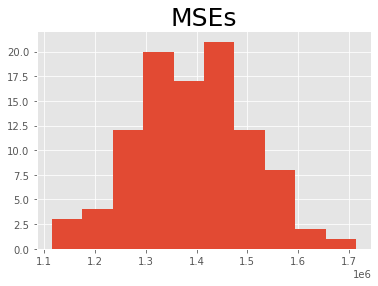

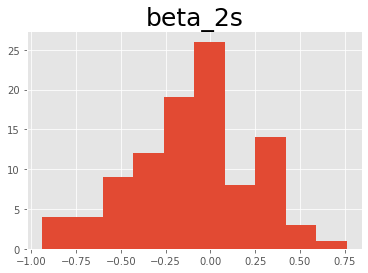

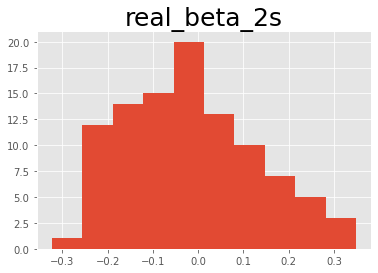

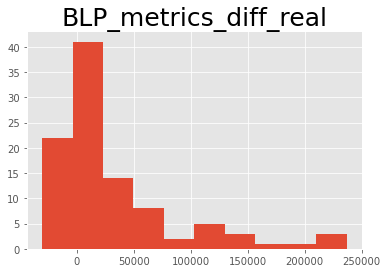

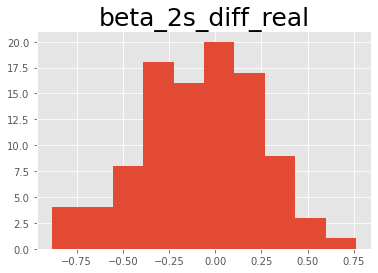

In [60]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = LGBMRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

# 3) Comparing two models (MSE tune VS target tuning) , given datasplit!!! For rf, ElasticNet and lgbm

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [26:47<00:00, 16.07s/it]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.00000,100.000000,100.000000
mean,10456.791530,43931.88477,-2.281180,-4110.897570
std,81497.321419,175053.07930,10.874601,21759.035711
min,-187023.769000,-406563.09000,-31.197000,-49814.531000
25%,-17365.525500,-68111.71625,-9.816750,-22551.609500
50%,2290.849000,39224.12600,-1.238500,-953.416000
75%,27855.877250,137866.24275,5.830000,11068.268000
max,386135.017000,824308.09700,28.914000,49480.263000


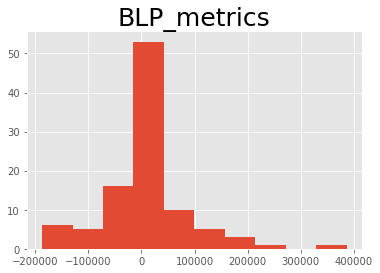

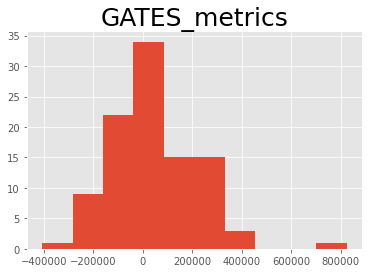

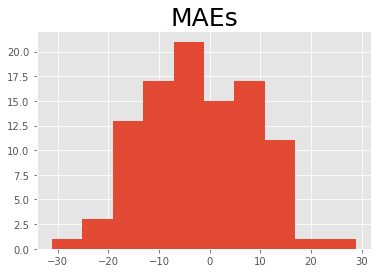

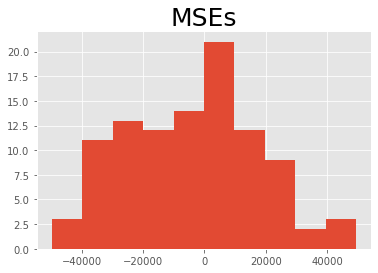

In [61]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = rf0_tune_MSE, model1_A = rf1_tune_Lambda_hat, 
                                                model0_B = rf0_tune_MSE, model1_B = rf1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+04, tolerance: 6.738e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.371e+04, tolerance: 1.030e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 14%|███████████▎                                                                     | 14/100 [00:12<01:12,  1.18it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.610e+03, tolerance: 5.816e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e+04, tolerance: 1.169e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 28%|██████████████████████▋                                                          | 28/100 [00:24<01:01,  1.17it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+04, tolerance: 7.581e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.307e+04, tolerance: 1.231e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 42%|██████████████████████████████████                                               | 42/100 [00:36<00:48,  1.20it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+04, tolerance: 6.278e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.333e+04, tolerance: 1.306e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:48<00:37,  1.19it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.088e+04, tolerance: 6.472e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.134e+04, tolerance: 1.309e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:59<00:25,  1.15it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+04, tolerance: 6.984e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.791e+04, tolerance: 1.316e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:12<00:16,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.970e+03, tolerance: 5.476e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+04, tolerance: 1.206e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:25<00:01,  1.12it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+04, tolerance: 6.505e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+04, tolerance: 9.394e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.00000,1.000000e+02
mean,37012.553400,-49045.857890,258.06521,7.792975e+05
std,53951.444105,157109.322675,61.10969,2.032686e+05
min,-20078.923000,-569739.305000,121.28100,3.468180e+05
25%,2940.690250,-141332.698000,219.61500,6.613611e+05
50%,15047.427500,-43308.777000,260.80950,7.619122e+05
75%,43856.704000,41505.835500,294.32950,9.166330e+05
max,264157.099000,462257.620000,445.34700,1.488470e+06


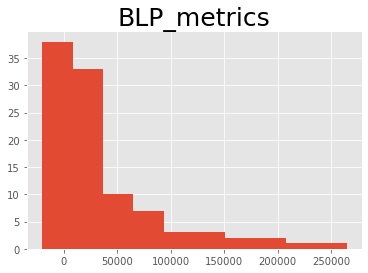

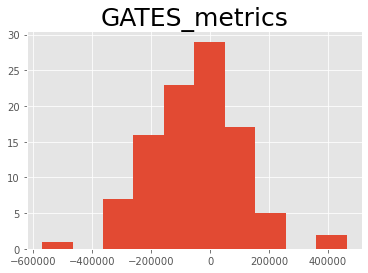

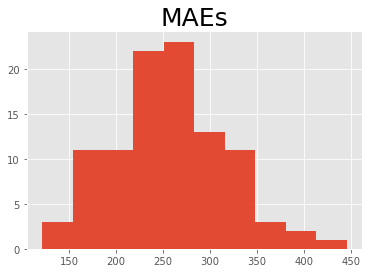

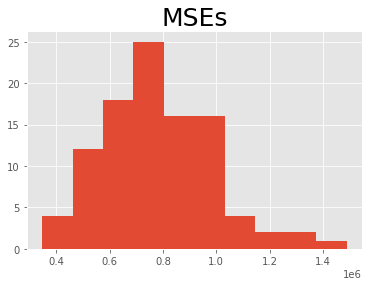

In [62]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = elast0_tune_MSE, model1_A = elast1_tune_Lambda_hat, 
                                                model0_B = elast0_tune_MSE, model1_B = elast1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 120.134793


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 120.134793
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_col_wise=true` to remove the overhead.


  1%|▊                                                                                 | 1/100 [00:00<01:14,  1.33it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -79.525936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 26.466318


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 26.466318
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.


  2%|█▋                                                                                | 2/100 [00:01<01:14,  1.32it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 7.682612
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -19.553582


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -19.553582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004826 seconds.
You can set `force_col_wise=true` to remove the overhead.


  3%|██▍                                                                               | 3/100 [00:02<01:15,  1.29it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -12.791247


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 6.203464


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 6.203464
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

  4%|███▎                                                                              | 4/100 [00:03<01:15,  1.28it/s]


[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -151.160423
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004666 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 125.559480


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 125.559480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.


  5%|████                                                                              | 5/100 [00:03<01:14,  1.28it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -88.020900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004027 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 120.919751


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 120.919751
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004511 seconds.
You can set `force_col_wise=true` to remove the overhead.


  6%|████▉                                                                             | 6/100 [00:04<01:14,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 9.969196
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004638 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 118.777798


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 118.777798
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_col_wise=true` to remove the overhead.


  7%|█████▋                                                                            | 7/100 [00:05<01:13,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -221.532280


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 116.837352


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 116.837352
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004556 seconds.
You can set `force_col_wise=true` to remove the overhead.


  8%|██████▌                                                                           | 8/100 [00:06<01:12,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -39.341847
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004081 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 146.246201


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 146.246201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_col_wise=true` to remove the overhead.


  9%|███████▍                                                                          | 9/100 [00:07<01:11,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -223.851919


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 108.639998


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 108.639998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_col_wise=true` to remove the overhead.

 10%|████████                                                                         | 10/100 [00:07<01:11,  1.26it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 24.145887
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004487 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 71.823791


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 71.823791
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_col_wise=true` to remove the overhead.


 11%|████████▉                                                                        | 11/100 [00:08<01:10,  1.26it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -189.912902


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 11.090255


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 11.090255
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -108.267079


 12%|█████████▋                                                                       | 12/100 [00:09<01:09,  1.27it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 102.400706


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 102.400706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016


 13%|██████████▌                                                                      | 13/100 [00:10<01:08,  1.28it/s]

[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -344.341740
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004245 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 158.710168


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 158.710168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_col_wise=true` to remove the overhead.


 14%|███████████▎                                                                     | 14/100 [00:11<01:07,  1.27it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 1264
[LightGBM] [Info] Start training from score -259.002370
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 203.166915


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 203.166915


 15%|████████████▏                                                                    | 15/100 [00:11<01:06,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -92.949317


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 21.382264


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 21.382264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004111 seconds.
You can set `force_col_wise=true` to remove the overhead.


 16%|████████████▉                                                                    | 16/100 [00:12<01:06,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -14.147765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003800 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 35.383070


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 35.383070
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004530 seconds.
You can set `force_col_wise=true` to remove the overhead.


 17%|█████████████▊                                                                   | 17/100 [00:13<01:05,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -217.698846
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003866 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score 57.483718


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score 57.483718
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 18%|██████████████▌                                                                  | 18/100 [00:14<01:05,  1.26it/s]

[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 1264
[LightGBM] [Info] Start training from score -35.520060
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 124.023844


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 124.023844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004451 seconds.
You can set `force_col_wise=true` to remove the overhead.


 19%|███████████████▍                                                                 | 19/100 [00:14<01:04,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -35.817690


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -26.159404


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -26.159404
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004855 seconds.
You can set `force_col_wise=true` to remove the overhead.


 20%|████████████████▏                                                                | 20/100 [00:15<01:03,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score -127.996329


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 34.946647


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 34.946647


 21%|█████████████████                                                                | 21/100 [00:16<01:06,  1.19it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 86.313324


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 147.207118


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 147.207118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_col_wise=true` to remove the overhead.


 22%|█████████████████▊                                                               | 22/100 [00:17<01:04,  1.22it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -399.621885
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -57.119419


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -57.119419
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_col_wise=true` to remove the overhead.


 23%|██████████████████▋                                                              | 23/100 [00:18<01:02,  1.23it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -263.005430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004382 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 103.481578


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 103.481578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003126 seconds.
You can set `force_col_wise=true` to remove the overhead.


 24%|███████████████████▍                                                             | 24/100 [00:19<01:01,  1.24it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -218.342152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 133.356554


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 133.356554
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 25%|████████████████████▎                                                            | 25/100 [00:19<00:59,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -115.635317
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 89.515550


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 89.515550


 26%|█████████████████████                                                            | 26/100 [00:20<00:58,  1.26it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -251.903007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 81.462070


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 81.462070
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 27%|█████████████████████▊                                                           | 27/100 [00:21<00:57,  1.28it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -115.568144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -62.618554


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -62.618554
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_col_wise=true` to remove the overhead.


 28%|██████████████████████▋                                                          | 28/100 [00:22<00:56,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 177.733724
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 5.790481


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score 5.790481
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004997 seconds.
You can set `force_col_wise=true` to remove the overhead.

 29%|███████████████████████▍                                                         | 29/100 [00:22<00:55,  1.27it/s]


[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score -102.188186


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 129.219529


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score 129.219529
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_col_wise=true` to remove the overhead.


 30%|████████████████████████▎                                                        | 30/100 [00:23<00:55,  1.26it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -214.873417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 119.577765


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 119.577765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_col_wise=true` to remove the overhead.


 31%|█████████████████████████                                                        | 31/100 [00:24<00:54,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -153.500874
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 52.593439


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 52.593439


 32%|█████████████████████████▉                                                       | 32/100 [00:25<00:53,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -277.607414


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 141.308459


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 141.308459
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004154 seconds.
You can set `force_col_wise=true` to remove the overhead.


 33%|██████████████████████████▋                                                      | 33/100 [00:26<00:52,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -389.864892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -13.960701


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -13.960701
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 34%|███████████████████████████▌                                                     | 34/100 [00:26<00:51,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -253.512379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 160.966371


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 160.966371
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_col_wise=true` to remove the overhead.


 35%|████████████████████████████▎                                                    | 35/100 [00:27<00:51,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -58.346636
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 96.482308


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 96.482308
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_col_wise=true` to remove the overhead.


 36%|█████████████████████████████▏                                                   | 36/100 [00:28<00:50,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -202.299827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 144.574383


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 144.574383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_col_wise=true` to remove the overhead.


 37%|█████████████████████████████▉                                                   | 37/100 [00:29<00:49,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -80.637517
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005414 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 162.579345


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 162.579345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_col_wise=true` to remove the overhead.


 38%|██████████████████████████████▊                                                  | 38/100 [00:30<00:48,  1.27it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -206.339251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 14.823559


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 14.823559
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003418 seconds.
You can set `force_col_wise=true` to remove the overhead.


 39%|███████████████████████████████▌                                                 | 39/100 [00:30<00:48,  1.27it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 54.575330


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -82.227581


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -82.227581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003974 seconds.
You can set `force_col_wise=true` to remove the overhead.


 40%|████████████████████████████████▍                                                | 40/100 [00:31<00:47,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 28.625858
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 112.185191


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 112.185191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488


 41%|█████████████████████████████████▏                                               | 41/100 [00:32<00:46,  1.27it/s]

[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score 85.154324
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004356 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 162.013644


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 162.013644


 42%|██████████████████████████████████                                               | 42/100 [00:33<00:45,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -106.335879


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40448
[LightGBM] [Info] Number of data points in the train set: 92, number of used features: 1264
[LightGBM] [Info] Start training from score 32.782028


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40448
[LightGBM] [Info] Number of data points in the train set: 92, number of used features: 1264
[LightGBM] [Info] Start training from score 32.782028
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 43%|██████████████████████████████████▊                                              | 43/100 [00:34<00:45,  1.25it/s]

[LightGBM] [Info] Total Bins 18960
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 1264
[LightGBM] [Info] Start training from score -137.448014


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 137.969728


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 137.969728
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_col_wise=true` to remove the overhead.


 44%|███████████████████████████████████▋                                             | 44/100 [00:34<00:44,  1.25it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score -370.065787
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003871 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 91.017954


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 91.017954


 45%|████████████████████████████████████▍                                            | 45/100 [00:35<00:43,  1.25it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -91.923356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 207.204002


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 207.204002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005152 seconds.
You can set `force_col_wise=true` to remove the overhead.


 46%|█████████████████████████████████████▎                                           | 46/100 [00:36<00:43,  1.25it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -415.756123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 122.167075


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 122.167075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_col_wise=true` to remove the overhead.


 47%|██████████████████████████████████████                                           | 47/100 [00:37<00:42,  1.25it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -372.594222
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 127.928542


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 127.928542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003588 seconds.
You can set `force_col_wise=true` to remove the overhead.


 48%|██████████████████████████████████████▉                                          | 48/100 [00:38<00:41,  1.26it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -99.192868


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 16.286898


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 16.286898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003722 seconds.
You can set `force_col_wise=true` to remove the overhead.

 49%|███████████████████████████████████████▋                                         | 49/100 [00:38<00:40,  1.25it/s]


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -125.598245


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 184.651251


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 184.651251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.


 50%|████████████████████████████████████████▌                                        | 50/100 [00:39<00:39,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -289.134256
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004320 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 9.964629


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 9.964629
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004214 seconds.
You can set `force_col_wise=true` to remove the overhead.


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:40<00:38,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 83.672731


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 39.829346


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score 39.829346


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
 52%|██████████████████████████████████████████                                       | 52/100 [00:41<00:39,  1.21it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score 25.096703
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 38.581759


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 38.581759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_col_wise=true` to remove the overhead.


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:42<00:38,  1.23it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -50.976946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004037 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 182.981919


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 182.981919
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004339 seconds.
You can set `force_col_wise=true` to remove the overhead.


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:42<00:37,  1.24it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -122.073040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -18.931946


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -18.931946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_col_wise=true` to remove the overhead.


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:43<00:36,  1.24it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -144.720585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 56.449034


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 56.449034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004725 seconds.
You can set `force_col_wise=true` to remove the overhead.


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:44<00:35,  1.25it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -301.848255
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 148.459116


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 148.459116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_col_wise=true` to remove the overhead.


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:45<00:34,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -354.242490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 19.528771


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 19.528771
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:46<00:33,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -112.488085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -15.736725


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -15.736725


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:46<00:32,  1.26it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 95.077605


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 161.568672


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 161.568672
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:47<00:31,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -184.598926
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 74.445494


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 74.445494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:48<00:30,  1.26it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -125.469768


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -53.255120


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -53.255120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003014 seconds.
You can set `force_col_wise=true` to remove the overhead.


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:49<00:30,  1.26it/s]

[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 30.495448
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 29.806810


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 29.806810
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004480 seconds.
You can set `force_col_wise=true` to remove the overhead.


 63%|███████████████████████████████████████████████████                              | 63/100 [00:49<00:29,  1.26it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -150.075881
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -33.948083


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -33.948083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_col_wise=true` to remove the overhead.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:50<00:28,  1.27it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -163.655510


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 117.607994


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 117.607994
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:51<00:27,  1.27it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -379.367317
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003998 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 46.670563


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 46.670563
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_col_wise=true` to remove the overhead.


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:52<00:26,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -19.941335
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 101.173109


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 101.173109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:53<00:26,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -261.235639
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 69.768157


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 69.768157
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_col_wise=true` to remove the overhead.


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:53<00:25,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -95.061182
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 166.260193


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 166.260193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:54<00:24,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -1.521289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 102.141208


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 102.141208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:55<00:23,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -256.434997


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 209.211502


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score 209.211502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:56<00:22,  1.27it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 1264
[LightGBM] [Info] Start training from score -289.033414
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 21.152798


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 21.152798
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:57<00:22,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -255.509753
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 72.750408


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 72.750408
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_col_wise=true` to remove the overhead.


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:57<00:21,  1.27it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -66.331436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 119.434195


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 119.434195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005178 seconds.
You can set `force_col_wise=true` to remove the overhead.


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:58<00:20,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -161.905435
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 67.477634


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score 67.477634
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_col_wise=true` to remove the overhead.


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:59<00:19,  1.27it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 1264
[LightGBM] [Info] Start training from score -113.190759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003964 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 20.458295


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 20.458295


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:00<00:20,  1.19it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -52.753184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 280.508014


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 280.508014
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003019 seconds.
You can set `force_col_wise=true` to remove the overhead.


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:01<00:19,  1.21it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -189.613993


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -46.041503


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -46.041503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_col_wise=true` to remove the overhead.


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:02<00:17,  1.22it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -69.390000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score 139.547117


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score 139.547117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_col_wise=true` to remove the overhead.


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:02<00:16,  1.24it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score -91.375890


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 158.326134


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score 158.326134
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:03<00:16,  1.24it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score -91.076680
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 46.302940


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 46.302940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:04<00:15,  1.25it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 13.664707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -24.426913


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -24.426913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:05<00:14,  1.25it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 150.822665
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 34.480840


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 34.480840
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_col_wise=true` to remove the overhead.


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:05<00:13,  1.26it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -309.239850


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 51.556983


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 51.556983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_col_wise=true` to remove the overhead.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:06<00:12,  1.26it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -64.061700
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 99.255637


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 99.255637
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_col_wise=true` to remove the overhead.


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:07<00:11,  1.26it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -175.185547
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 51.848439


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 51.848439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003871 seconds.
You can set `force_col_wise=true` to remove the overhead.


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:08<00:11,  1.27it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 53.714313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 58.608344


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 58.608344
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_col_wise=true` to remove the overhead.


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:09<00:10,  1.27it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 62.470679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 29.015909


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 29.015909
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_col_wise=true` to remove the overhead.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:09<00:09,  1.26it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -261.067615


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 58.125060


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 58.125060
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_col_wise=true` to remove the overhead.


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:10<00:08,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -37.375155


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 107.727256


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 107.727256


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:11<00:07,  1.26it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -187.981445
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 34.092139


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 34.092139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004142 seconds.
You can set `force_col_wise=true` to remove the overhead.


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:12<00:07,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -27.556252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 24.640817


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 24.640817


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:13<00:06,  1.27it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -309.835397


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 151.436738


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score 151.436738


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:13<00:05,  1.27it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -153.847623


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 36.017398


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 36.017398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003795 seconds.
You can set `force_col_wise=true` to remove the overhead.


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:14<00:04,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -206.650335
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -40.602600


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -40.602600
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_col_wise=true` to remove the overhead.


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:15<00:03,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 354.233820
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 91.865881


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 91.865881
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_col_wise=true` to remove the overhead.


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:16<00:03,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -67.856888
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004047 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 11.687802


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 11.687802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_col_wise=true` to remove the overhead.


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:17<00:02,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -1.337304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 81.421985


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 81.421985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_col_wise=true` to remove the overhead.


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:17<00:01,  1.27it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -182.395298
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004021 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 87.567044


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 87.567044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_col_wise=true` to remove the overhead.


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:18<00:00,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -157.616178
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 39.685278


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 39.685278
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 77.313477
Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.000000,100.000000
mean,1536.473550,5055.734240,3.078340,4544.106100
std,54022.250302,166081.283338,5.142603,10038.271542
min,-152903.572000,-344773.182000,-8.493000,-18849.567000
25%,-23091.218750,-90892.095250,-0.377750,-3135.624000
50%,-986.670000,-11983.525500,2.871000,3597.876500
75%,16894.109000,80122.833750,6.317250,10206.989500
max,206686.062000,450981.842000,15.721000,29764.898000


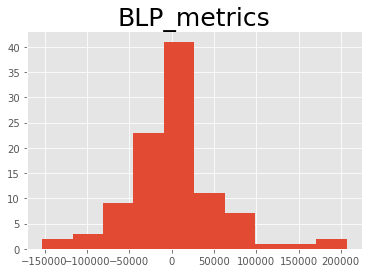

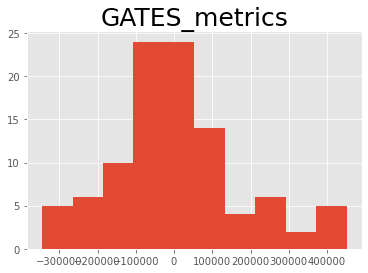

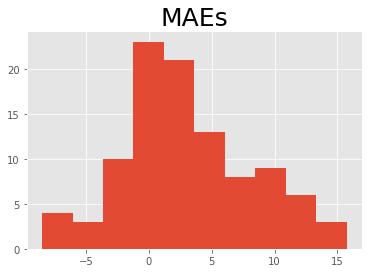

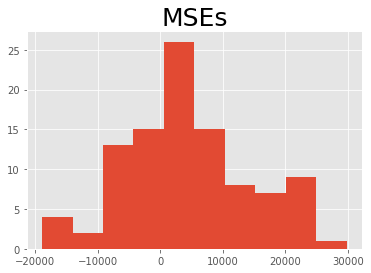

In [63]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = lgbm0_tune_MSE, model1_A = lgbm1_tune_Lambda_hat, 
                                                model0_B = lgbm0_tune_MSE, model1_B = lgbm1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

In [64]:
lgbm1_tune_MSE.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.02,
 'importance_type': 'split',
 'learning_rate': 0.003,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 2,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': False,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [65]:
lgbm1_tune_Lambda_hat.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.02,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 3,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# 4) Baseline models and estimations to compare previous results with 

# Note: even if p > n like in this case, LinearRegression works!!!! I think this is so, because instead of inverting matrices, there is kinda gradient descent/Adam algorithm!!!

## a) Baseline model (linear regression), mechanism like in the paper and in the code above

In [66]:
linreg0 = LinearRegression()
linreg1 = LinearRegression()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,26864.666710,222285.848990,902.314500,1.258607e+06,7403.145750,-0.016400,-0.086190
std,43910.453114,137620.076574,57.497196,1.493130e+05,9787.686188,0.398843,0.187526
min,19.709000,37721.449000,756.339000,9.213006e+05,0.751000,-1.340000,-0.623000
25%,2310.454500,135421.331750,868.814500,1.153003e+06,1113.409250,-0.234250,-0.214000
50%,11131.007000,201221.421500,905.584500,1.259869e+06,3972.773500,0.032500,-0.100000
75%,37470.821500,285103.687750,943.151500,1.351672e+06,10857.265750,0.259000,0.040500
max,350759.545000,923495.034000,1154.514000,2.080537e+06,69119.986000,0.958000,0.332000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-85.029,-1464.664,1374.401,-1502.500,-1674.663,-1325.780
G2,-158.039,-1557.108,1215.158,-701.166,-790.576,-621.536
G3,-221.223,-1624.240,1080.655,-172.358,-273.491,-71.571
G4,-264.740,-1609.349,1056.838,411.011,324.615,502.791
G5,-99.723,-1495.460,1220.193,1305.191,1014.268,1597.015


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-85.029,-1464.664,1374.401,-1502.500,-1674.663,-1325.780
x1,0.951,0.328,1.598,0.922,0.274,1.560
x4,9.095,7.434,10.708,8.918,7.102,10.726
x5,35.208,31.583,39.097,34.823,30.809,38.712
x6,-6.442,-9.877,-3.345,-5.811,-8.603,-2.931
...,...,...,...,...,...,...
x1270,-1.133,-2.604,0.354,-1.029,-2.793,0.693
x1271,0.158,-1.163,1.503,0.546,-0.981,2.062
x1272,1.874,0.223,3.448,1.818,0.054,3.649
x1273,-0.137,-2.074,1.789,0.749,-1.146,2.594


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-99.723,-1495.460,1220.193,1305.191,1014.268,1597.015
x1,0.960,0.334,1.603,1.308,0.709,1.894
x4,9.244,7.703,10.812,9.113,7.675,10.542
x5,34.706,30.840,38.417,35.347,31.472,39.247
x6,-6.522,-9.780,-3.233,-6.037,-9.187,-2.921
...,...,...,...,...,...,...
x1270,-1.000,-2.623,0.709,-1.482,-3.061,0.063
x1271,1.069,-0.405,2.556,0.397,-1.127,1.916
x1272,1.966,0.386,3.567,1.869,0.324,3.521
x1273,0.630,-1.385,2.728,-0.189,-2.063,1.757


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-70.385,-2092.710,1960.339,2783.397,2453.985,3129.462
x1,0.027,-0.864,0.907,0.406,-0.487,1.296
x4,0.123,-2.178,2.416,0.322,-2.028,2.590
x5,-0.686,-6.225,4.734,0.711,-4.908,6.250
x6,0.043,-4.498,4.802,-0.304,-4.495,3.935
...,...,...,...,...,...,...
x1270,0.084,-2.104,2.323,-0.457,-2.763,1.865
x1271,0.816,-1.204,2.804,-0.080,-2.143,1.960
x1272,0.160,-2.131,2.411,0.094,-2.240,2.530
x1273,0.705,-2.090,3.622,-0.917,-3.543,1.735


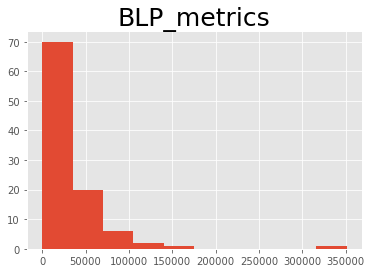

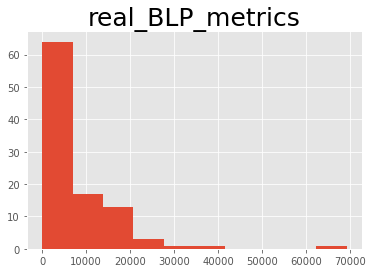

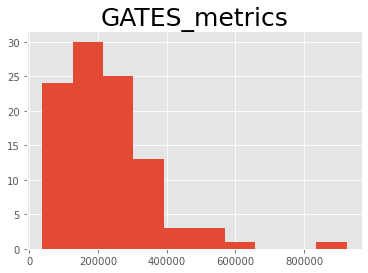

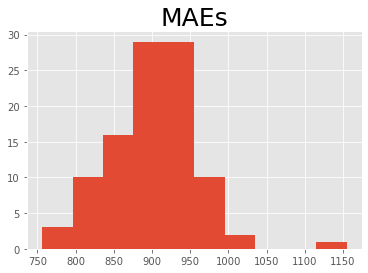

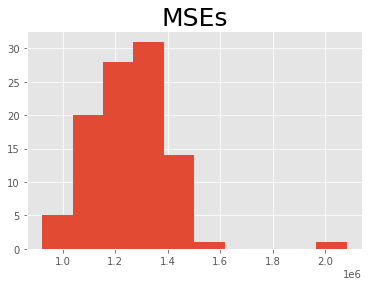

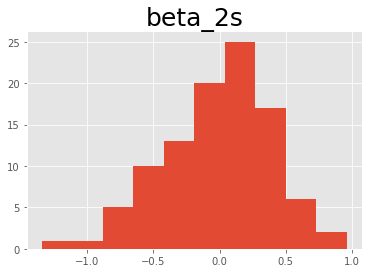

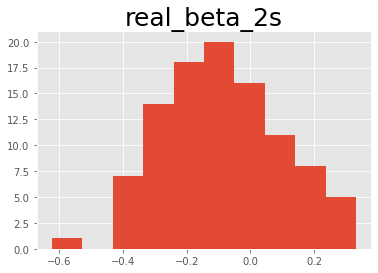

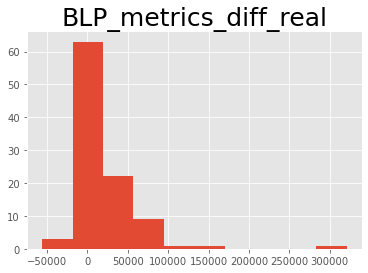

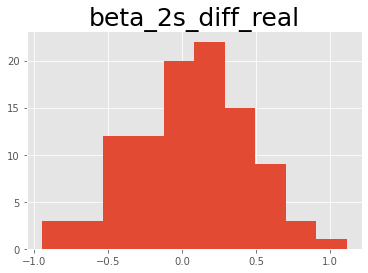

In [67]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = linreg0, model1 = linreg1, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

## b) Naive strategy: just coef to D of simple regression with OOF metrics!!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.91it/s]

Metrics table


,MAEs,MSEs
count,100.000000,1.000000e+02
mean,822.310190,1.020314e+06
std,39.120667,9.046053e+04
min,749.116000,8.192983e+05
25%,792.110000,9.585008e+05
50%,821.575500,1.020093e+06
75%,852.773750,1.089617e+06
max,920.066000,1.216335e+06


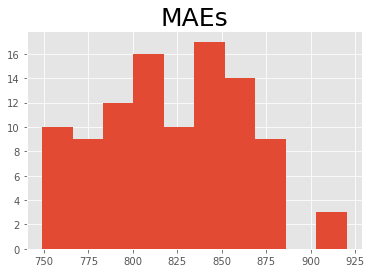

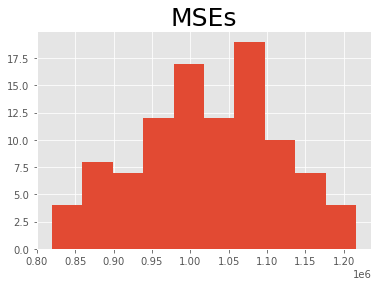

In [68]:
df_metrics =\
        term_paper_main_func_easy_baseline(df = df.copy(), n_splits = 100, extended = True)